In [229]:
from random import randint, random, sample, shuffle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.linalg import eigvals
from scipy.stats import linregress, norm
from math import factorial
import networkx as nx
from itertools import combinations, chain
from collections import Counter, defaultdict
import matplotlib as mpl
from scipy import stats
%matplotlib inline
c = %config InlineBackend.rc
c['savefig.dpi'] = 100
%config InlineBackend.figure_format='png'
%config InlineBackend.rc = c
%matplotlib inline

In [35]:
# Adding utils directory to the path
from pathlib import Path
cwd = Path.cwd()
import sys
sys.path.append(str(cwd.parent.joinpath("utils")))

# Importing custom collections of utils
import az_tools as az
reload(az)
import az_model as azm
reload(azm)
import az_plot as azp
reload(azp)

In [2]:
from cycler import cycler
colors=[u'#1b9e77', u'#d95f02', u'#7570b3', u'#e7298a', u'#66a61e', u'#e6ab02', u'#a6761d', u'#666666']
almost_black = "0.2"
mpl.rcParams['axes.edgecolor'] = almost_black
mpl.rcParams['axes.labelcolor'] = almost_black
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.prop_cycle'] = cycler(u'color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['legend.fontsize'] = "medium"
mpl.rcParams['legend.numpoints'] = 1
mpl.rcParams['legend.scatterpoints'] = 1
mpl.rcParams['legend.edgecolor'] = "w"
mpl.rcParams['legend.loc'] = "upper left"
mpl.rcParams['text.color'] = almost_black
mpl.rcParams['xtick.color'] = almost_black
mpl.rcParams['ytick.color'] = almost_black
mpl.rcParams['figure.facecolor'] = "w"

def hide_axis(ax):
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

### Utils

Adjacency matrices

In [3]:
list_genotypes = ['AA', 'AC', 'AU', 'AG', 'CA', 'CC', 'CU', 'CG', 'UA', 'UC', 'UU', 'UG', 'GA', 'GC', 'GU', 'GG']

A = pd.read_csv("PNAS_matrix.csv", header=None).values.astype("float")
B = np.zeros(A.shape)
for i in range(int(A.shape[0])):
    for j in range(int(A.shape[0])):
        if A[i,j] > 0.01:
            B[i,j] = A[i,j]
A = A.T
B = B.T

Misc

In [4]:
get_bin = lambda x: format(x, 'b').zfill(16)
bin_to_bool = lambda x: x == '1'
mask = np.vectorize(bin_to_bool)

#C(n,k)
def k_n(k,n):
    return factorial(n)/(factorial(k)*factorial(n-k))

#Put zeroes on the diagonal of a matrix
def del_diag(x):
    return x - np.diag(np.diag(x))

#Transform list of genotypes into network string and vice-versa
def transform(x):
    list_genotypes = ['AA', 'AC', 'AU', 'AG', 'CA', 'CC', 'CU', 'CG', 'UA', 'UC', 'UU', 'UG', 'GA', 'GC', 'GU', 'GG']
    if type(x) == list:
        s = ""
        for g in list_genotypes:
            if g in x:
                s += '1'
            else:
                s += '0'
        return s
    else:
        s = []
        for i in range(16):
            if x[i] == '1':
                s.append(list_genotypes[i])
        return s

Graph related

In [5]:
#Returns adjacency matrix for a network
def adj_matrix(x, WC=False):
    if type(x) == list:
        return adj_matrix(transform(x), WC=WC)
    else:
        if WC == False:
            return A[mask(list(x))][:,mask(list(x))]
        else:
            return B[mask(list(x))][:,mask(list(x))]

#Returns a Networkx graph object for a network
def graph(x, WC=False):
    if type(x) == list:
        return graph(transform(x),WC=WC)
    else:
        return nx.from_numpy_matrix(adj_matrix(x, WC=WC), create_using=nx.DiGraph())

#Returns relaxation time for an adjacency matrix which is 1/(lambda_1 - lambda_2)
def relaxation(x):
    eig = sorted(np.real(eigvals(x)), reverse=True)
    if len(eig) == 1:
        return 0
    else:
        return 1.0/(eig[0]-eig[1])

#Returns the second eigenvalue of the directed normalized Laplacian 
def dir_laplacian(x):
    try:
        L = nx.directed_laplacian_matrix(x)
        return np.sort(np.real(eigvals(L)))[1]
    except:
        return None

Conductance related

In [6]:
#Returns the conductance of graph G
#It is computed over all cuts on G
def min_conductance(G):
    nodes = list(G.nodes_iter())
    n = G.number_of_nodes()
    
    if n == 1:
        return 0
    
    return min([min([conductance(G,x) for x in combinations(nodes, i)]) for i in range(1, n/2+1)])

#Returns the conductance of set of nodes S of graph G
def conductance(G, S, T=None, weight='weight'):
    if T is None:
            T = set(G) - set(S)
    num_cut_edges = cut_size(G, S, T, weight=weight)
    volume_S = volume(G, S, weight=weight)
    volume_T = volume(G, T, weight=weight)
    return num_cut_edges / min(volume_S, volume_T)

#Returns the volume of the boundary of set of edges S of graph G
def cut_size(G, S, T=None, weight='weight'):
    if T is None:
        T = set(G) - set(S)
    edges = edge_boundary(G, S, T, data=weight, default=None)
    if G.is_directed():
        edges = chain(edges, edge_boundary(G, T, S, data=weight, default=None))
    return sum(weight for u, v, weight in edges)

#Returns the set of edges which constitutes the boundary of set of edges S of graph G
def edge_boundary(G, nbunch1, nbunch2=None, data='weight', keys=False,
                  default=None):
    nset1 = {v for v in G if v in nbunch1}
    if G.is_multigraph():
        edges = G.edges(nset1, data=data, keys=keys, default=default)
    else:
        edges = G.edges(nset1, data=data, default=default)
    if nbunch2 is None:
        return (e for e in edges if e[1] not in nset1)
    nset2 = set(nbunch2)
    return (e for e in edges if e[1] in nset2)

#Returns the volume of set of edges S of graph G
def volume(G, S, weight='weight'):
    degree = G.out_degree if G.is_directed() else G.degree
    return sum(degree(S, weight=weight).values())

Draw networks

In [7]:
#Draw a network (only Watson-Crick interactions) with network string or list of genotypes
def az_draw(x):
    if type(x) == str:
        g = graph(x, WC=True)
        nodes = dict(enumerate(transform(x)))
        g = nx.relabel_nodes(g, nodes)
        nx.draw(g, arrows=True, with_labels=True, node_color="w", node_size=600)
    if type(x) == list:
        az_draw(transform(x))

### Read data from csv file

In [8]:
df = pd.read_csv("az_networks_data.csv")
df["nt_str"] = df["nt_id"].map(get_bin)
print(df.sample(2))

       avg_connectivity  conductance  flow_hierarchy     growth    lam2_L  \
9447           0.700000     0.688752        0.404831  20.234719  0.591127   
56135          0.696429     0.685265        0.463386  13.865341  0.572303   

       mean_sa    mean_w  nt_id            nt_str  relaxation  scc  size_nt  \
9447   0.00995  0.007911   9448  0010010011101000   31.657184    4        6   
56135  0.00695  0.008353  56136  1101101101001000   17.550035    5        8   

         var_in    var_ou    var_sa  
9447   0.000208  0.000227  0.000139  
56135  0.001567  0.000447  0.000175  


In [9]:
df.flow_hierarchy.fillna(0, inplace=True)
df.lam2_L.fillna(0, inplace=True)

### Computes data

In [ ]:
%%time
df = pd.DataFrame(range(1,2**16), columns=['nt_id'])
df["nt_str"] = df["nt_id"].map(get_bin)
df["nodes"] = df["nt_str"].map(transform)
df["adj"] = df["nt_str"].map(lambda x: A[mask(list(x))][:,mask(list(x))])
df["adj_wc"] = df["nt_str"].map(lambda x: B[mask(list(x))][:,mask(list(x))])
df["nt"] = df["adj"].map(lambda x: nx.from_numpy_matrix(x, create_using=nx.DiGraph()))
df["nt_wc"] = df["adj_wc"].map(lambda x: nx.from_numpy_matrix(x, create_using=nx.DiGraph()))
df["avg_connectivity"] = df["nt_wc"].map(nx.average_node_connectivity)
df["scc"] = df["nt_wc"].map(nx.number_strongly_connected_components)
df["flow_hierarchy"] = df["nt_wc"].map(lambda x: nx.flow_hierarchy(x, weight='weight') if x.size() > 0 else None)
df["size_nt"] = df["nt_str"].map(lambda x: x.count("1"))
df["growth"] = df["adj"].map(lambda x: 1.0/max(sorted(np.real(eigvals(x)), reverse=True))) 
df["relaxation"] = df["adj"].map(relaxation)
df["mean_w"] = df["adj"].map(np.mean)
df["var_out"] = df["adj"].map(lambda x: np.var(del_diag(x).sum(1)))
df["var_in"] = df["adj"].map(lambda x: np.var(del_diag(x).sum(0)))
df["mean_sa"] = df["adj"].map(lambda x: np.diag(x).mean())
df["var_sa"] = df["adj"].map(lambda x: np.diag(x).var())
df["lam2_L"] = df["nt"].map(dir_laplacian)

In [ ]:
%%time
# This takes a lot of time (2**32)
df["conductance"] = df["nt"].map(min_conductance)

In [ ]:
#Save data:
col_to_save = df.columns[:2]+df.columns[7:]
print(col_to_save)
df.get(col_to_save).to_csv("az_networks_data.csv", index=False)

### Scatter matrix

In [ ]:
x = df[df.size_nt > 2].get(["mean_w", "var_ou", "growth", "scc", "relaxation"])
col = x.columns
x = x.values
nb_var = len(col)

f, axarr = plt.subplots(nb_var, nb_var)
f.set_figheight(nb_var**2.2)
f.set_figwidth(nb_var**2.2)

for i in range(nb_var):
    for j in range(nb_var):
        ax = axarr[i,j]
        if i == j:
            ax.hist(x[:,i],bins=50)
            ax.set_xlabel(col[i], fontsize=30)
        else:
            ax.plot(x[:,j], x[:,i], '.')
            ax.set_xlabel(col[j], fontsize=30)
            ax.set_ylabel(col[i], fontsize=30)

In [ ]:
#Careful this loads seaborn
col = df.columns
x = df[df.size_nt > 1].get(col[7:])
corr = x.corr()
import seaborn as sns
sns.heatmap(corr)
sns.set()

### Colored scatter plots

In [9]:
def colored_scatter(df, x_var, y_var, size_lb=0, size_ub=16, ax=None):
    if ax == None:
        f = plt.figure()
        ax = plt.gca()
    
    data = df[(df.size_nt >= size_lb) & (df.size_nt <= size_ub)]
    print(data.shape)
    cmap = plt.get_cmap("viridis")
    colors = cmap.colors[::16]
    
    x = data[x_var].values
    
    y = data[y_var].values
    hue = [colors[s-1] for s in data["size_nt"].values]
    
    ax.scatter(x,y,c=hue,linewidths=0, s=5)
    
    """
    for i in range(len(x)):
        ax.plot(x[i], y[i], '.', c=hue[i])
    """
    ax.set_xlabel(x_var)
    ax.set_ylabel(y_var)

(8008, 15)


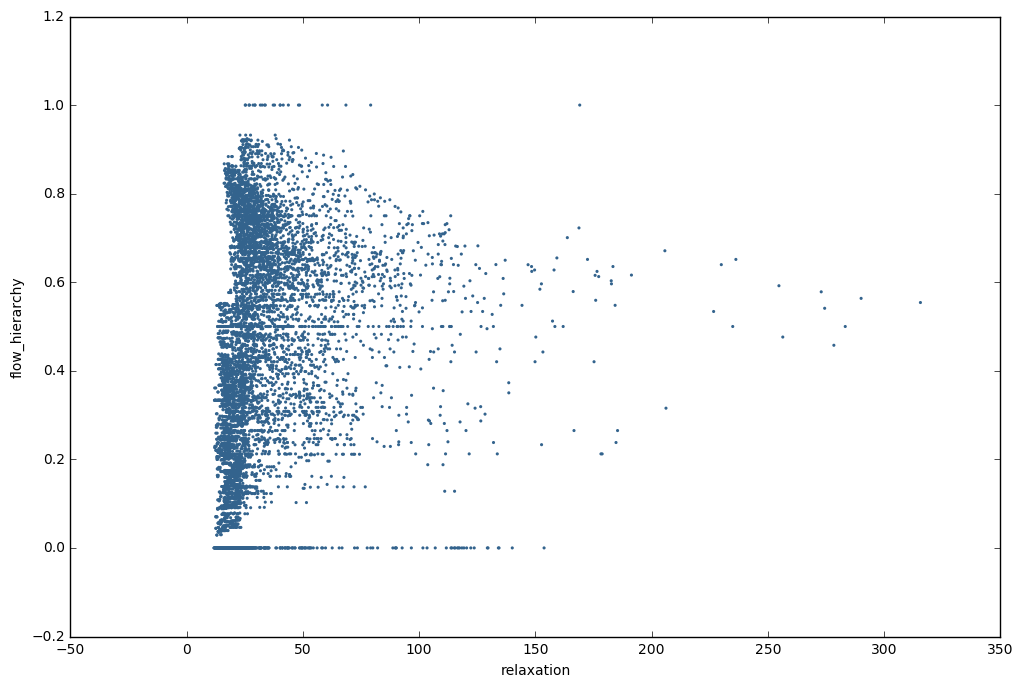

In [390]:
f = plt.figure(figsize=(12,8))
ax = plt.gca()
colored_scatter(df, "relaxation", "flow_hierarchy", size_lb=6, size_ub=6, ax=ax)

### Networks extremas

In [13]:
def draw_extrema(df, variable, size=None, nb=1):
    data = df
    if size != None: 
        if type(size) == list:
            data = data[data.size_nt.isin(size)]
        else:
            data = data[data.size_nt == size]
    data = data.sort_values(by=variable, ascending=False)
    
    for i in range(nb):
        f = plt.figure(figsize=(4,4))
        az_draw(data[:i+1][-1:].nt_str.values[0])
        plt.text(0.5,-0.2,"%s = %s"%(variable, data[:i+1][-1:][variable].values[0]), ha='center')
    
    for i in range(nb):
        f = plt.figure(figsize=(4,4))
        az_draw(data[-1-i:][:1].nt_str.values[0])
        plt.text(0.5,-0.2,"%s = %s"%(variable, data[-1-i:][:1][variable].values[0]), ha='center')

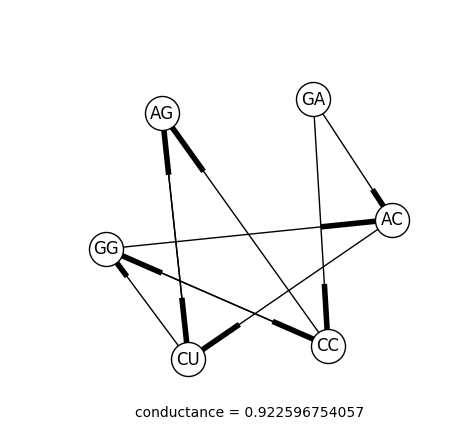

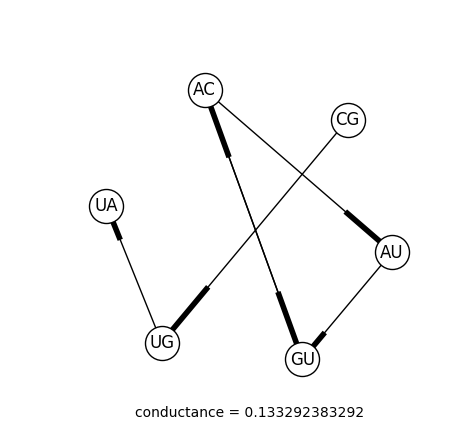

In [51]:
draw_extrema(df_fusion, 'conductance', size=6, nb=1)

### Pick starting emulsions

In [10]:
def mixing():
    mix = [0,0.05,0.40,0.50,0.05]
    #mix = [0,0.01,0.01,0.97,0.01]
    for i in range(4):
        mix[i+1] += mix[i]
    x = random()
    p = -1
    for i in range(5):
        if x < mix[-i]:
            p = 5-i
    return p

def mix_wells(wells, nb_fusion=10000):
    #This uses the dataframe with all the data for all networks called df    
    
    fusion = []

    for _ in xrange(nb_fusion):
        p = mixing()
        droplet = transform(list(set(chain.from_iterable(sample(wells, p)))))
        fusion.append(droplet)
    
    return df[df.nt_str.isin(fusion)]

In [713]:
#First try
wells = [
    ["AA"],
    ["CC"],
    ["UU"],
    ["GG"],
    ["AU"],
    ["GC"],
    ["AC"],
    ["GU"],
    ["GA"],
    ["CU"],
    ["UC"],
    ["UG"],
    ["AU","UA"],
    ["GC","CG"],
    ["AC","GU"],
    ["AC","CC"],
    ["AA","CC","UU"],
    ["GG","GC","CC"],
    ["CU","UG","AA"],
    ["AG","CU","CG"],
    ["AG","UC","GA","CU"],
    ["AA","UU","GG","CC"],
    ["AU","UA","AA","UU"],
    ["GC","CG","GG","CC"],
]
print(wells)
well_sizes = [len(x) for x in wells]
print(wells, len(wells), np.mean(well_sizes), np.var(well_sizes))

[['AA'], ['CC'], ['UU'], ['GG'], ['AU'], ['GC'], ['AC'], ['GU'], ['GA'], ['CU'], ['UC'], ['UG'], ['AU', 'UA'], ['GC', 'CG'], ['AC', 'GU'], ['AC', 'CC'], ['AA', 'CC', 'UU'], ['GG', 'GC', 'CC'], ['CU', 'UG', 'AA'], ['AG', 'CU', 'CG'], ['AG', 'UC', 'GA', 'CU'], ['AA', 'UU', 'GG', 'CC'], ['AU', 'UA', 'AA', 'UU'], ['GC', 'CG', 'GG', 'CC']]
([['AA'], ['CC'], ['UU'], ['GG'], ['AU'], ['GC'], ['AC'], ['GU'], ['GA'], ['CU'], ['UC'], ['UG'], ['AU', 'UA'], ['GC', 'CG'], ['AC', 'GU'], ['AC', 'CC'], ['AA', 'CC', 'UU'], ['GG', 'GC', 'CC'], ['CU', 'UG', 'AA'], ['AG', 'CU', 'CG'], ['AG', 'UC', 'GA', 'CU'], ['AA', 'UU', 'GG', 'CC'], ['AU', 'UA', 'AA', 'UU'], ['GC', 'CG', 'GG', 'CC']], 24, 2.0, 1.3333333333333333)


In [712]:
#Second try based on extreme
wells = [
    ["GC","GA"],
    ["CC","UG"],
    ["GA","CA"],
    ["CA","GC"],
    ["CU","GG"],
    ["AA","GU"],
    ["AU","UU"],
    ["GC","UC"],
    ["CG","UG"],
    ["CU","AG"],
    ["AC","GU"],
    ["GG","CC"],
    ["AU","GU","AG"],
    ["CG","CU","GC"],
    ["UU","GA","UA"],
    ["UG","GG","UC"],
    ["AU","AG","GU"],
    ["CU","CG","GG"],
    ["AC","AA","AU"],
    ["GA","CG","UA"],
    ["GG","GU","CG","AG"],
    ["AC","CU","CC","AU"],
    ["GC","AC","UA","CG"],
    ["CA","AU","GA","AA"],
]
well_sizes = [len(x) for x in wells]
print(wells, len(wells), np.mean(well_sizes), np.var(well_sizes))

[['GC', 'GA'], ['CC', 'UG'], ['GA', 'CA'], ['CA', 'GC'], ['CU', 'GG'], ['AA', 'GU'], ['AU', 'UU'], ['GC', 'UC'], ['CG', 'UG'], ['CU', 'AG'], ['AC', 'GU'], ['GG', 'CC'], ['AU', 'GU', 'AG'], ['CG', 'CU', 'GC'], ['UU', 'GA', 'UA'], ['UG', 'GG', 'UC'], ['AU', 'AG', 'GU'], ['CU', 'CG', 'GG'], ['AC', 'AA', 'AU'], ['GA', 'CG', 'UA'], ['GG', 'GU', 'CG', 'AG'], ['AC', 'CU', 'CC', 'AU'], ['GC', 'AC', 'UA', 'CG'], ['CA', 'AU', 'GA', 'AA']]
([['GC', 'GA'], ['CC', 'UG'], ['GA', 'CA'], ['CA', 'GC'], ['CU', 'GG'], ['AA', 'GU'], ['AU', 'UU'], ['GC', 'UC'], ['CG', 'UG'], ['CU', 'AG'], ['AC', 'GU'], ['GG', 'CC'], ['AU', 'GU', 'AG'], ['CG', 'CU', 'GC'], ['UU', 'GA', 'UA'], ['UG', 'GG', 'UC'], ['AU', 'AG', 'GU'], ['CU', 'CG', 'GG'], ['AC', 'AA', 'AU'], ['GA', 'CG', 'UA'], ['GG', 'GU', 'CG', 'AG'], ['AC', 'CU', 'CC', 'AU'], ['GC', 'AC', 'UA', 'CG'], ['CA', 'AU', 'GA', 'AA']], 24, 2.6666666666666665, 0.55555555555555547)


In [711]:
#Third try: result of 10k iteration
wells = [
 ['UU'],
 ['UC'],
 ['UU'],
 ['AC'],
 ['GC'],
 ['UA'],
 ['AU'],
 ['CG'],
 ['CA', 'AA'],
 ['GU', 'GA'],
 ['CC', 'UC'],
 ['AG', 'AA'],
 ['GA', 'GU', 'UA'],
 ['AA', 'AG', 'CC'],
 ['AU', 'UG', 'GA'],
 ['GG', 'AU', 'CG'],
 ['GC', 'GG', 'AU', 'AC'],
 ['AC', 'GG', 'UG', 'CU'],
 ['UG', 'CU', 'CA', 'UC'],
 ['GG', 'GA', 'AG', 'AA']
]
well_sizes = [len(x) for x in wells]
print(wells, len(wells), np.mean(well_sizes), np.var(well_sizes))

([['UU'], ['UC'], ['UU'], ['AC'], ['GC'], ['UA'], ['AU'], ['CG'], ['CA', 'AA'], ['GU', 'GA'], ['CC', 'UC'], ['AG', 'AA'], ['GA', 'GU', 'UA'], ['AA', 'AG', 'CC'], ['AU', 'UG', 'GA'], ['GG', 'AU', 'CG'], ['GC', 'GG', 'AU', 'AC'], ['AC', 'GG', 'UG', 'CU'], ['UG', 'CU', 'CA', 'UC'], ['GG', 'GA', 'AG', 'AA']], 20, 2.2000000000000002, 1.3599999999999999)


Concentrations

In [11]:
def equal_conc(wells, nb_fusion=10000):
    nb_mix = [mixing() for _ in range(nb_fusion)]
    var_conc = [np.var(Counter(chain.from_iterable(sample(wells, p))).values()) for p in nb_mix]
    return (var_conc.count(0)/float(nb_fusion))

Mix emulsions

In [707]:
nb_fusion = int(1e4)

fusion = []

for _ in xrange(nb_fusion):
    p = mixing()
    droplet = transform(list(set(chain.from_iterable(sample(wells, p)))))
    fusion.append(droplet)
    
print(len(set(fusion)))

df_fusion = df[df.nt_str.isin(fusion)]

print(df_fusion.shape)

1101
(1101, 15)


In [640]:
#All droplets not just unique ones
df_all = pd.concat([df[df.nt_str == x] for x in fusion], 0)
print(df_all.shape)

(10000, 15)


In [12]:
def compare_dist(sample, dist, variable, bins):
    f = plt.figure()
    ax = plt.gca()
    ax.hist(sample.get(variable), bins=bins, normed=True, alpha=0.5, lw=0, color=colors[0])
    ax.hist(dist.get(variable), bins=bins, normed=True, color=colors[1], alpha=0.5, lw=0)

### Starting wells design

Wall time: 27min 15s


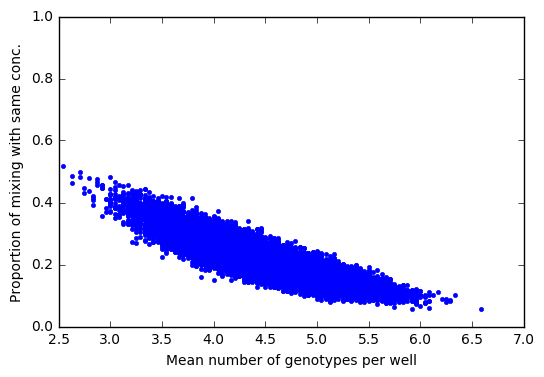

In [808]:
%%time
nb_fusion = int(1e3)
mean_wells = []
equal_conc = []

for N in range(50000):
    well_sizes = [randint(1,8) for _ in range(24)]
    wells = [sample(list_genotypes, i) for i in well_sizes]
    nb_mix = [mixing() for _ in range(nb_fusion)]
    mean_wells.append(np.mean(well_sizes))
    equal_conc.append([np.var(Counter(chain.from_iterable(sample(wells, p))).values()) for p in nb_mix].count(0)/float(nb_fusion))
    
f = plt.figure()
ax = plt.gca()
ax.plot(mean_wells, equal_conc, '.')
#ax.set_xlim(0,8)
ax.set_ylim(0,1)
ax.set_xlabel("Mean number of genotypes per well")
ax.set_ylabel("Proportion of mixing with same conc.")

Wall time: 34.2 s


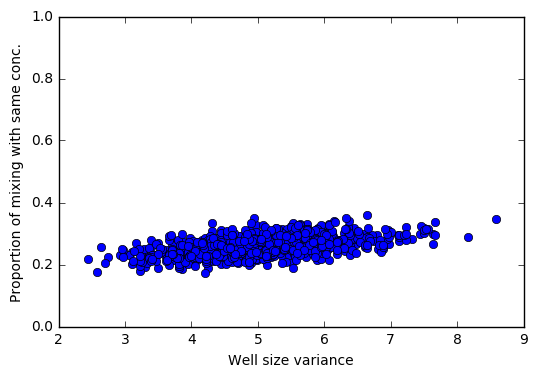

In [681]:
%%time
nb_fusion = int(1e3)
equal_conc = []
var_wells = []
mean_wells = []

for __ in range(1000):
    well_sizes = [randint(1,8) for _ in range(24)]
    c = 0
    while np.mean(well_sizes) >= 4.2 or np.mean(well_sizes) <= 3.8:
        well_sizes = [randint(1,8) for _ in range(24)]
        c += 1
        if c > 1000:
            print("Too many iterations")
            break
    mean_wells.append(np.mean(well_sizes))
    var_wells.append(np.var(well_sizes))
    wells = [sample(list_genotypes, i) for i in well_sizes]
    nb_mix = [mixing() for _ in range(nb_fusion)]
    equal_conc.append([np.var(Counter(chain.from_iterable(sample(wells, p))).values()) for p in nb_mix].count(0)/float(nb_fusion))
    
f = plt.figure()
ax = plt.gca()
ax.plot(var_wells, equal_conc, 'o')
#ax.set_xlim(0,8)
ax.set_ylim(0,1)
ax.set_xlabel("Well size variance")
ax.set_ylabel("Proportion of mixing with same conc.")

0
Wall time: 13.5 s


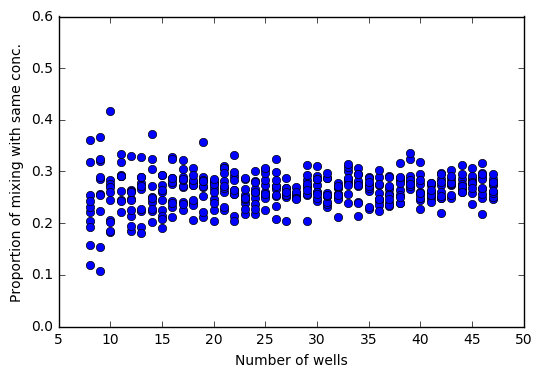

In [800]:
%%time
nb_fusion = int(1e3)
equal_conc = []
nb_wells = []
mean_wells = []
too_many = 0

for N in range(8,48):
    for _ in range(10):
        well_sizes = [randint(1,8) for _ in range(N)]
        c = 0
        while np.mean(well_sizes) >= 4.05 or np.mean(well_sizes) <= 3.95:
            well_sizes = [randint(1,8) for _ in range(N)]
            c += 1
            if c > 1000:
                too_many += 1
                break
        mean_wells.append(np.mean(well_sizes))
        nb_wells.append(N)
        wells = [sample(list_genotypes, i) for i in well_sizes]
        nb_mix = [mixing() for _ in range(nb_fusion)]
        equal_conc.append([np.var(Counter(chain.from_iterable(sample(wells, p))).values()) for p in nb_mix].count(0)/float(nb_fusion))
    
print(too_many)
f = plt.figure()
ax = plt.gca()
ax.plot(nb_wells, equal_conc, 'o')
#ax.set_xlim(0,8)
ax.set_ylim(0,0.6)
ax.set_xlabel("Number of wells")
ax.set_ylabel("Proportion of mixing with same conc.")

Wall time: 1h 4min 49s


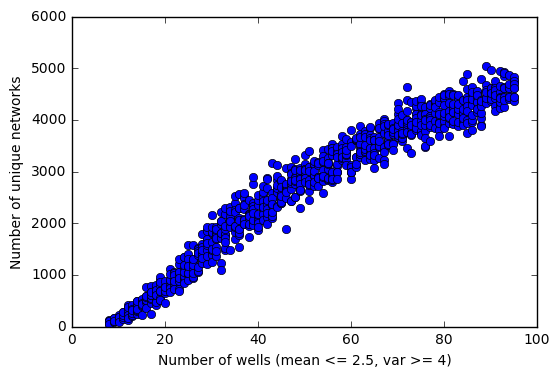

In [803]:
%%time
nb_fusion = int(1e4)
unique_nt = []
nb_wells = []
var_wells = []
mean_wells = []
too_many = 0

for N in range(8,96):
    for __ in range(10):
        well_sizes = [randint(1,8) for _ in range(N)]
        c = 0
        while np.mean(well_sizes) >= 3:
            well_sizes = [randint(1,8) for _ in range(N)]
            c += 1
            if c > 100000:
                too_many += 1
                break
        nb_wells.append(N)
        mean_wells.append(np.mean(well_sizes))
        var_wells.append(np.var(well_sizes))

        wells = [sample(list_genotypes, i) for i in well_sizes]

        fusion = []

        for _ in xrange(nb_fusion):
            p = mixing()
            droplet = transform(list(set(chain.from_iterable(sample(wells, p)))))
            fusion.append(droplet)

        unique_nt.append(len(set(fusion)))
    
f = plt.figure()
ax = plt.gca()
ax.plot(nb_wells, unique_nt, 'o')
#ax.set_xlim(0,8)
#ax.set_ylim(0,1)
ax.set_xlabel("Number of wells (mean <= 2.5, var >= 4)")
ax.set_ylabel("Number of unique networks")

0
Wall time: 5min 12s


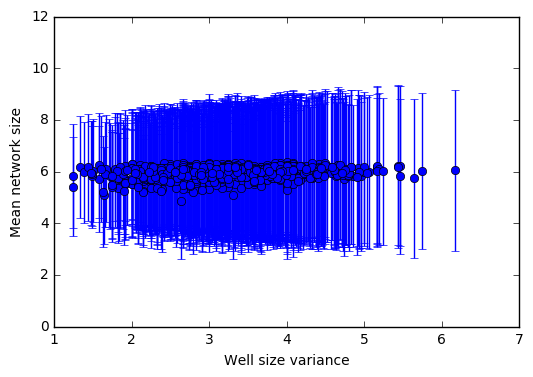

In [735]:
%%time
nb_fusion = int(1e3)
size_nt = []
std_size = []
var_wells = []
mean_wells = []
too_many = 0

for N in range(1000):
    well_sizes = [randint(1,8) for _ in range(24)]
    c = 0
    while np.mean(well_sizes) >= 2.8:
        well_sizes = [randint(1,8) for _ in range(24)]
        c += 1
        if c > 100000:
            too_many += 1
            print(too_many)
            break
    mean_wells.append(np.mean(well_sizes))
    var_wells.append(np.var(well_sizes))

    wells = [sample(list_genotypes, i) for i in well_sizes]

    fusion = []

    for _ in xrange(nb_fusion):
        p = mixing()
        droplet = transform(list(set(chain.from_iterable(sample(wells, p)))))
        fusion.append(droplet.count("1"))

    size_nt.append(np.mean(fusion))
    std_size.append(np.std(fusion))
    
f = plt.figure()
ax = plt.gca()
ax.errorbar(var_wells, size_nt, fmt='o', yerr=std_size)
#ax.set_xlim(0,8)
ax.set_ylim(0,12)
ax.set_xlabel("Well size variance")
ax.set_ylabel("Mean network size")
print(too_many)

In [757]:
%%time
nb_fusion = int(1e3)
equal_conc = []
too_many = 0

for N in range(1000):
    well_sizes = [1,1,1,1,1,1] + [randint(1,8) for _ in range(18)]
    c = 0
    while np.mean(well_sizes) >= 2.2:
        well_sizes = [1,1,1,1,1,1] + [randint(1,8) for _ in range(18)]
        c += 1
        if c > 100000:
            too_many += 1
            break
            
    wells = [sample(list_genotypes, i) for i in well_sizes]
    nb_mix = [mixing() for _ in range(nb_fusion)]
    equal_conc.append([np.var(Counter(chain.from_iterable(sample(wells, p))).values()) for p in nb_mix].count(0)/float(nb_fusion))

print(too_many)

0
Wall time: 4min 14s


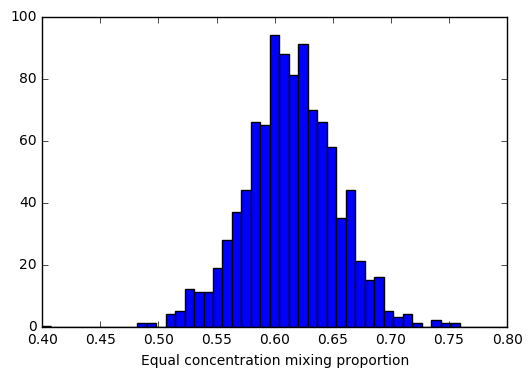

In [768]:
plt.hist(equal_conc, bins=np.linspace(0.4,0.8))
ax = plt.gca()
ax.set_xlabel("Equal concentration mixing proportion")

### Random sampling to maximise variance (or something else?)

In [831]:
%%time

variable = "conductance"

nb_fusion = int(1e4)

all_std = []
best = {}

too_many = 0

for N in xrange(1000):
    
    well_sizes = [1,1,1,1,1,1] + [randint(1,8) for _ in range(18)]
    c = 0
    while np.mean(well_sizes) >= 2.2:
        well_sizes = [1,1,1,1,1,1] + [randint(1,8) for _ in range(18)]
        c += 1
        if c > 100000:
            too_many += 1
            break
            
    wells = [sample(list_genotypes, i) for i in well_sizes]
    
    fusion = []

    for _ in xrange(nb_fusion):
        p = mixing()
        droplet = sample(wells, p)
        droplet = transform(list(set(chain.from_iterable(droplet))))
        fusion.append(droplet)

    std_temp = np.std(df[df.nt_str.isin(fusion)].get(variable).values)
    all_std.append(std_temp)
    
    if len(best) < 3:
        best[std_temp] = wells
    elif std_temp > min(best.keys()):
        best[std_temp] = wells
        del best[min(best.keys())]

print(too_many)
print(best)

0
{9.8919509790860332: [['CC'], ['GG'], ['AC'], ['GA'], ['UA'], ['CA'], ['UG'], ['GG', 'AG', 'UA', 'GC'], ['UA'], ['GG', 'AG'], ['UA', 'UU', 'AG', 'CG', 'GU', 'GG'], ['CA', 'AG', 'AC', 'CG', 'AA'], ['AA', 'GG'], ['CG'], ['UG', 'UA', 'GG'], ['UG'], ['UG'], ['AA', 'GA', 'CC'], ['GC', 'AC', 'UG'], ['CC'], ['AG'], ['UG', 'CA'], ['AA', 'GG', 'UG', 'AC', 'UC', 'CC'], ['AG']], 9.8051436824800273: [['UC'], ['AC'], ['AC'], ['CG'], ['UG'], ['CG'], ['AU'], ['UC'], ['UA', 'CA', 'UG'], ['AG', 'CU'], ['GA', 'CU', 'GU'], ['GA', 'UG'], ['AU', 'AG'], ['UG'], ['AC'], ['CU', 'CA'], ['AG'], ['CG', 'UA', 'GU', 'UG', 'CU', 'UC'], ['AA', 'UG', 'GA', 'UU'], ['AG', 'GG', 'UC', 'CG', 'GA', 'CC', 'UU', 'GU'], ['UC', 'AC', 'AG', 'CC'], ['GA'], ['CA'], ['UG']], 10.529829405671766: [['AA'], ['AG'], ['GC'], ['GG'], ['UA'], ['AG'], ['GU'], ['CG'], ['AA'], ['CA'], ['GA'], ['UG'], ['AG', 'CU'], ['CU', 'UU', 'GA', 'GC', 'AC', 'AG'], ['GA', 'UU', 'UC', 'AU', 'GG', 'CC'], ['AG', 'CG', 'GC', 'CC', 'AA', 'CA', 'UC'], ['UA']

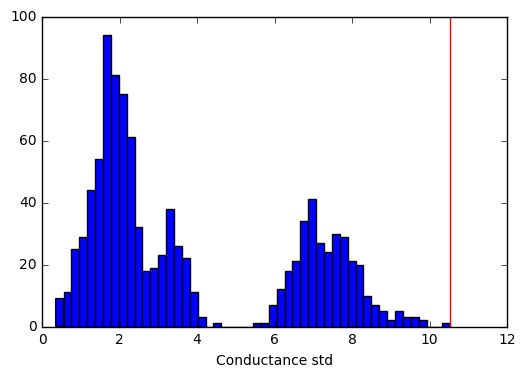

In [840]:
plt.hist(all_std, bins=50);
ax = plt.gca()
ax.set_xlabel("%s std"%(variable.upper()[0]+variable[1:]))
ax.plot([max(best.keys())]*100, np.linspace(0,100,100), "r")

In [833]:
wells = best[max(best.keys())]

nb_fusion = int(1e4)

fusion = []

for _ in xrange(nb_fusion):
    p = mixing()
    droplet = transform(list(set(chain.from_iterable(sample(wells, p)))))
    fusion.append(droplet)
    
print(len(set(fusion)))

df_fusion = df[df.nt_str.isin(fusion)]

503


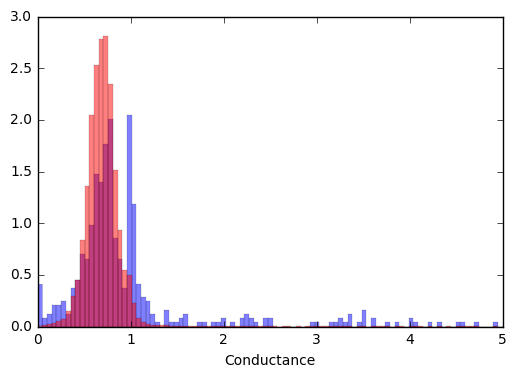

In [839]:
compare_dist(df_fusion, df, "conductance", np.linspace(0,5,100))
ax = plt.gca()
ax.set_xlabel("Conductance")

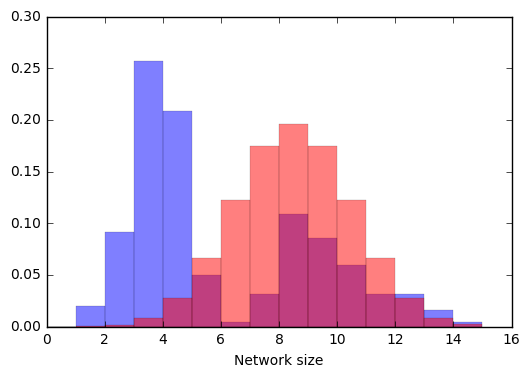

In [838]:
compare_dist(df_fusion, df, "size_nt", range(16))
ax = plt.gca()
ax.set_xlabel("Network size")

### Effect of maximizing variance on number of networks reached

In [841]:
%%time

variable = "conductance"

nb_fusion = int(1e4)

all_std = []
sample_size = []

too_many = 0

for N in xrange(1000):
    
    well_sizes = [1,1,1,1,1,1] + [randint(1,8) for _ in range(18)]
    c = 0
    while np.mean(well_sizes) >= 2.2:
        well_sizes = [1,1,1,1,1,1] + [randint(1,8) for _ in range(18)]
        c += 1
        if c > 100000:
            too_many += 1
            break
            
    wells = [sample(list_genotypes, i) for i in well_sizes]
    
    fusion = []

    for _ in xrange(nb_fusion):
        p = mixing()
        droplet = sample(wells, p)
        droplet = transform(list(set(chain.from_iterable(droplet))))
        fusion.append(droplet)

    std_temp = np.std(df[df.nt_str.isin(fusion)].get(variable).values)
    all_std.append(std_temp)
    sample_size.append(len(list(set(fusion))))
    
print(too_many)

0
Wall time: 4min 33s


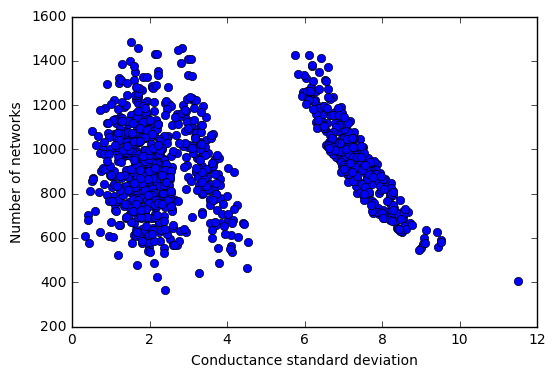

In [854]:
f = plt.figure()
ax = plt.gca()
ax.plot(all_std, sample_size, 'o')
ax.set_ylabel("Number of networks")
ax.set_xlabel("Conductance standard deviation")

### Sampling with entropy

Effect on number of networks reached

In [38]:
%%time

variable = "conductance"

nb_fusion = int(1e4)

ent_all = []
nb_networks = []

too_many = 0

for N in xrange(1000):
    
    well_sizes = [1,1,1,1,1,1] + [randint(1,8) for _ in range(18)]
    c = 0
    while np.mean(well_sizes) >= 2.2:
        well_sizes = [1,1,1,1,1,1] + [randint(1,8) for _ in range(18)]
        c += 1
        if c > 100000:
            too_many += 1
            break
            
    wells = [sample(list_genotypes, i) for i in well_sizes]
    
    fusion = []

    for _ in xrange(nb_fusion):
        p = mixing()
        droplet = sample(wells, p)
        droplet = transform(list(set(chain.from_iterable(droplet))))
        fusion.append(droplet)

    var_temp = df[df.nt_str.isin(fusion)].get(variable).values
    h = np.histogram(var_temp, bins=np.linspace(0,5,100), density=True)
    
    ent_all.append(stats.entropy(h[0]*(h[1][1] - h[1][0])))
    nb_networks.append(len(list(set(fusion))))
    
print(too_many)

0
Wall time: 4min 27s


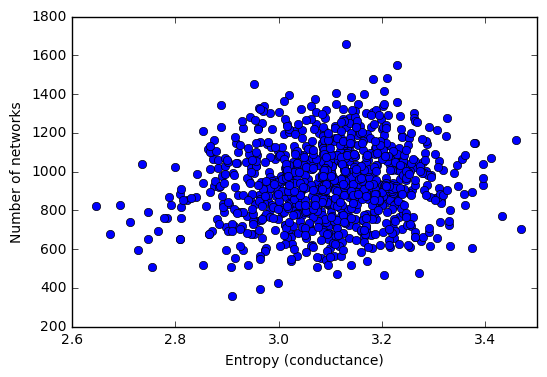

In [40]:
f = plt.figure()
ax = plt.gca()
ax.plot(ent_all, nb_networks, 'o')
ax.set_xlabel("Entropy (conductance)")
ax.set_ylabel("Number of networks")

In [42]:
%%time

variable = "conductance"

nb_fusion = int(1e4)

all_entropy = []
best = {}

too_many = 0

for N in xrange(10000):
    
    well_sizes = [1,1,1,1,1,1] + [randint(1,8) for _ in range(18)]
    c = 0
    while np.mean(well_sizes) >= 2.2:
        well_sizes = [1,1,1,1,1,1] + [randint(1,8) for _ in range(18)]
        c += 1
        if c > 100000:
            too_many += 1
            break
            
    wells = [sample(list_genotypes, i) for i in well_sizes]
    
    fusion = []

    for _ in xrange(nb_fusion):
        p = mixing()
        droplet = sample(wells, p)
        droplet = transform(list(set(chain.from_iterable(droplet))))
        fusion.append(droplet)
        
    var_temp = df[df.nt_str.isin(fusion)].get(variable).values
    h = np.histogram(var_temp, bins=np.linspace(0,5,100), density=True)
    
    ent_temp = stats.entropy(h[0]*(h[1][1] - h[1][0]))
    all_entropy.append(ent_temp)
    
    if len(best) < 3:
        best[ent_temp] = wells
    elif ent_temp > min(best.keys()):
        best[ent_temp] = wells
        del best[min(best.keys())]

print(too_many)
print(best)

0
{3.4798052988010539: [['CG'], ['UC'], ['CC'], ['UU'], ['CC'], ['GC'], ['UA'], ['GU'], ['UA'], ['UG', 'GA'], ['GU', 'CC', 'AA', 'CU', 'GA'], ['AU'], ['AG'], ['CG'], ['CC', 'AU', 'UC', 'UG', 'UU', 'CG'], ['UG', 'CU', 'UC', 'UU', 'CC', 'AU'], ['UU', 'CU'], ['CU'], ['GC', 'AA', 'CC', 'AG', 'GA', 'CG'], ['GA'], ['UA'], ['CG'], ['UC'], ['AG']], 3.4780753402337892: [['CC'], ['GC'], ['UU'], ['CA'], ['CU'], ['GA'], ['GC', 'GU', 'CG'], ['CG', 'GA'], ['GC'], ['CC'], ['CU', 'CA', 'UU', 'AA'], ['GA'], ['UU', 'AC', 'UG'], ['AG'], ['AC'], ['GG', 'AG', 'GC', 'UC', 'GU', 'UA', 'CU'], ['GU'], ['AA'], ['CC', 'CU'], ['UC'], ['UU'], ['GU', 'AA', 'CU', 'AC', 'AG', 'GG'], ['UU', 'GG', 'GA', 'UC', 'GC'], ['CU']], 3.5066797911586227: [['CC'], ['GG'], ['GC'], ['UC'], ['CU'], ['AA'], ['UU'], ['GA'], ['UG', 'GC', 'AA', 'AC', 'CU', 'AG', 'CG'], ['GG'], ['UC'], ['CU', 'AC'], ['UG'], ['GA'], ['GG', 'AU', 'CC', 'GA', 'GU', 'AA'], ['CG'], ['GC'], ['GG'], ['GU'], ['AG', 'GA'], ['UG', 'GU', 'AU', 'AC', 'UA'], ['GA', '

### Entropic solution

In [148]:
bins = {'avg_connectivity':np.linspace(0,3,50), 
        'scc':range(12), 
        'flow_hierarchy':np.linspace(0,1,50),
        'size_nt':range(16),
        'growth':np.linspace(0,60,100),
        'relaxation':np.linspace(0,100,100)
       }

In [14]:
def best_wells(variables, nb_iterations, nb=3):
    
    all_entropy = defaultdict(list)
    best = {}

    too_many = 0

    for N in xrange(nb_iterations):
        
        well_sizes = [1,1,1,1,1,1] + [randint(1,8) for _ in range(18)]
        c = 0
        while np.mean(well_sizes) >= 2.2:
            well_sizes = [1,1,1,1,1,1] + [randint(1,8) for _ in range(18)]
            c += 1
            if c > 100000:
                too_many += 1
                break

        wells = [sample(list_genotypes, i) for i in well_sizes]

        fusion = mix_wells(wells)

        var_temp = fusion.get(variables).values
        ent_temp = []
        for i, variable in enumerate(variables):
            h = np.histogram(var_temp[:,i], bins=bins[variable], density=True)
            ent_temp.append(stats.entropy(h[0]*(h[1][1] - h[1][0])))
            #all_entropy[variable].append(ent_temp[-1])

        if len(best) < nb:
            best[sum(ent_temp)] = wells
        elif sum(ent_temp) > min(best.keys()):
            best[sum(ent_temp)] = wells
            del best[min(best.keys())]
        
    print(too_many)
    return (best, all_entropy)

In [17]:
%%time
best, all_entropy = best_wells(bins.keys(), 100000)
print(best)

1
{19.033637595999583: [['GU'], ['AC'], ['UC'], ['UA'], ['AA'], ['CA'], ['AA'], ['UC'], ['AA'], ['GU', 'CA', 'CG', 'GA'], ['AA', 'GC', 'GA', 'AG'], ['CU'], ['GC'], ['GU', 'CC'], ['UA', 'AG', 'AU', 'UG', 'CA'], ['UU'], ['UU', 'CA'], ['UU'], ['UA', 'UC', 'GC'], ['GC', 'UA'], ['GU', 'CU', 'AA'], ['CG', 'UU', 'GC'], ['AA', 'AC', 'UU'], ['GA', 'UG', 'UC', 'AG', 'AA', 'GG', 'AC', 'CC']], 19.046634373806359: [['UA'], ['CA'], ['GA'], ['UA'], ['UC'], ['GC'], ['GA'], ['CU', 'UG'], ['AC'], ['CA', 'GA', 'CG', 'UA', 'AU'], ['GG', 'GC'], ['UA'], ['CA', 'UC', 'GA', 'CC'], ['AC', 'AG'], ['UA', 'GU', 'GG', 'CG', 'UG', 'AG', 'UU', 'UC'], ['GG'], ['AU', 'CA', 'AA', 'AG'], ['GC'], ['GU'], ['CC', 'GU', 'CA'], ['GG', 'GU', 'CC'], ['UU', 'CU'], ['CU', 'CA'], ['UC']], 19.01394837223982: [['AC'], ['GC'], ['GU'], ['UC'], ['UA'], ['UC'], ['AC'], ['UG'], ['CU', 'UU', 'AU', 'AA', 'UC', 'GU', 'CA'], ['GG'], ['AA', 'UG', 'GC'], ['UA'], ['UA'], ['AA', 'CG', 'CC', 'UU', 'GA', 'GU', 'UC'], ['CA'], ['GA', 'GU', 'AA'], [

In [18]:
best

{19.01394837223982: [['AC'],
  ['GC'],
  ['GU'],
  ['UC'],
  ['UA'],
  ['UC'],
  ['AC'],
  ['UG'],
  ['CU', 'UU', 'AU', 'AA', 'UC', 'GU', 'CA'],
  ['GG'],
  ['AA', 'UG', 'GC'],
  ['UA'],
  ['UA'],
  ['AA', 'CG', 'CC', 'UU', 'GA', 'GU', 'UC'],
  ['CA'],
  ['GA', 'GU', 'AA'],
  ['GA', 'CG', 'AU'],
  ['GG'],
  ['UU', 'GG'],
  ['UC'],
  ['GG', 'UA', 'AG', 'UG', 'AC'],
  ['UA'],
  ['UA', 'AG', 'CG', 'CA'],
  ['UU']],
 19.033637595999583: [['GU'],
  ['AC'],
  ['UC'],
  ['UA'],
  ['AA'],
  ['CA'],
  ['AA'],
  ['UC'],
  ['AA'],
  ['GU', 'CA', 'CG', 'GA'],
  ['AA', 'GC', 'GA', 'AG'],
  ['CU'],
  ['GC'],
  ['GU', 'CC'],
  ['UA', 'AG', 'AU', 'UG', 'CA'],
  ['UU'],
  ['UU', 'CA'],
  ['UU'],
  ['UA', 'UC', 'GC'],
  ['GC', 'UA'],
  ['GU', 'CU', 'AA'],
  ['CG', 'UU', 'GC'],
  ['AA', 'AC', 'UU'],
  ['GA', 'UG', 'UC', 'AG', 'AA', 'GG', 'AC', 'CC']],
 19.046634373806359: [['UA'],
  ['CA'],
  ['GA'],
  ['UA'],
  ['UC'],
  ['GC'],
  ['GA'],
  ['CU', 'UG'],
  ['AC'],
  ['CA', 'GA', 'CG', 'UA', 'AU'],
  ['G

In [19]:
winning = best[max(best.keys())]
winning

[['UA'],
 ['CA'],
 ['GA'],
 ['UA'],
 ['UC'],
 ['GC'],
 ['GA'],
 ['CU', 'UG'],
 ['AC'],
 ['CA', 'GA', 'CG', 'UA', 'AU'],
 ['GG', 'GC'],
 ['UA'],
 ['CA', 'UC', 'GA', 'CC'],
 ['AC', 'AG'],
 ['UA', 'GU', 'GG', 'CG', 'UG', 'AG', 'UU', 'UC'],
 ['GG'],
 ['AU', 'CA', 'AA', 'AG'],
 ['GC'],
 ['GU'],
 ['CC', 'GU', 'CA'],
 ['GG', 'GU', 'CC'],
 ['UU', 'CU'],
 ['CU', 'CA'],
 ['UC']]

In [212]:
winning_plus_10000 = [['UA'],
 ['GC'],
 ['CC'],
 ['GU'],
 ['CU'],
 ['GU', 'GA'],
 ['AU', 'CG'],
 ['AC', 'CA', 'GA'],
 ['GU', 'UA'],
 ['GC', 'GU', 'GG'],
 ['UC'],
 ['AU', 'UA', 'AG', 'AA'],
 ['UU'],
 ['GA'],
 ['UA', 'AC'],
 ['UC', 'AU', 'CU', 'CC', 'UG'],
 ['GG', 'UA', 'CG', 'AC', 'CC'],
 ['CC', 'AA'],
 ['GU', 'GA', 'AG'],
 ['AC', 'CU', 'GU'],
 ['GC', 'CG', 'AU', 'CA'],
 ['AC'],
 ['AA'],
 ['GG']]

In [26]:
winning_plus_100k = [['UA'],
 ['CA'],
 ['GA'],
 ['AG'],
 ['CU'],
 ['GC'],
 ['UU'],
 ['CU', 'UG'],
 ['AC'],
 ['CA', 'GA', 'CG', 'UA', 'AU'],
 ['GG', 'GC'],
 ['AU'],
 ['CA', 'UC', 'GA', 'CC'],
 ['AC', 'AG'],
 ['UA', 'GU', 'GG', 'CG', 'UG', 'AG', 'UU', 'UC'],
 ['GG'],
 ['AU', 'CA', 'AA', 'AG'],
 ['GC'],
 ['GU'],
 ['CC', 'GU', 'CA'],
 ['GG', 'GU', 'CC'],
 ['UU', 'CU'],
 ['CU', 'CA'],
 ['UC']]

In [61]:
print(winning_plus_100k)

[['UA'], ['CA'], ['GA'], ['AG'], ['CU'], ['GC'], ['UU'], ['CU', 'UG'], ['AC'], ['CA', 'GA', 'CG', 'UA', 'AU'], ['GG', 'GC'], ['AU'], ['CA', 'UC', 'GA', 'CC'], ['AC', 'AG'], ['UA', 'GU', 'GG', 'CG', 'UG', 'AG', 'UU', 'UC'], ['GG'], ['AU', 'CA', 'AA', 'AG'], ['GC'], ['GU'], ['CC', 'GU', 'CA'], ['GG', 'GU', 'CC'], ['UU', 'CU'], ['CU', 'CA'], ['UC']]


In [27]:
l = []
for e in winning_plus_100k:
    l += e
len(set(l))

16

In [28]:
temp = mix_wells(winning_plus_100k)
print(temp.sample(3))
print("")
print("%s different networks"%temp.shape[0])
print("%.2f equal concentration"%equal_conc(best[max(best.keys())]))

     avg_connectivity  conductance  flow_hierarchy     growth    lam2_L  \
583          0.333333     1.400778        0.000000  52.487510  1.080729   
577          0.166667     2.256098        1.000000  77.480959  0.937930   
735          0.166667     1.093190        0.666667  38.397781  0.905013   

      mean_sa    mean_w  nt_id            nt_str  relaxation  scc  size_nt  \
583  0.001567  0.005756    584  0000001001001000   50.719751    2        3   
577  0.004433  0.004589    578  0000001001000010   79.918206    3        3   
735  0.006525  0.005506    736  0000001011100000   38.481752    4        4   

       var_in    var_ou    var_sa  
583  0.000019  0.000073  0.000002  
577  0.000024  0.000076  0.000013  
735  0.000226  0.000091  0.000059  

1228 different networks
0.64 equal concentration


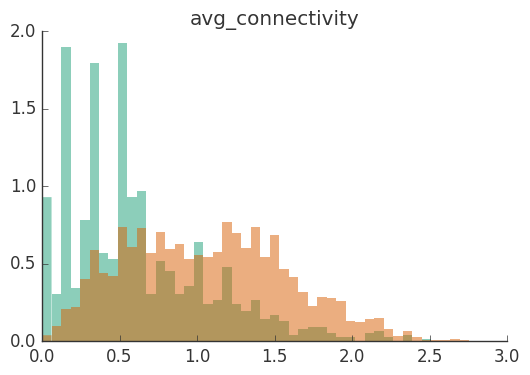

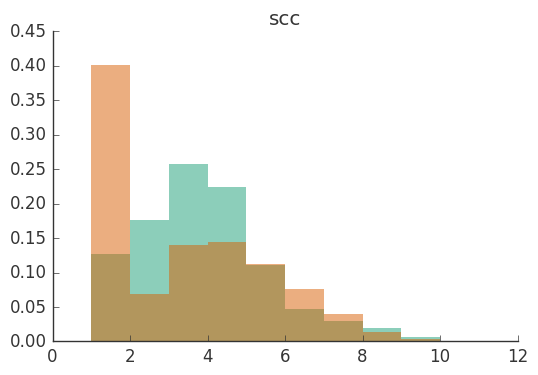

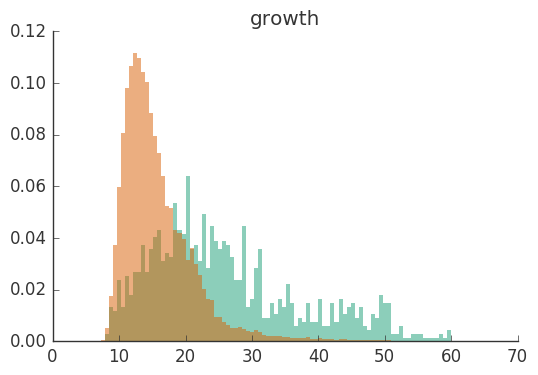

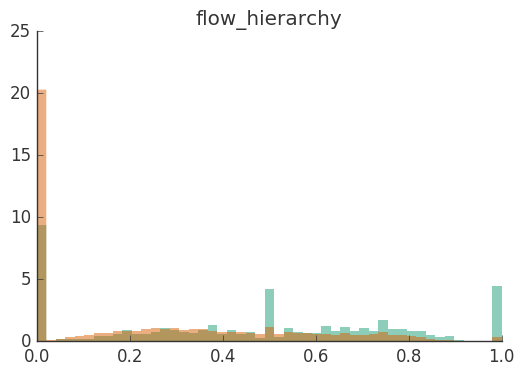

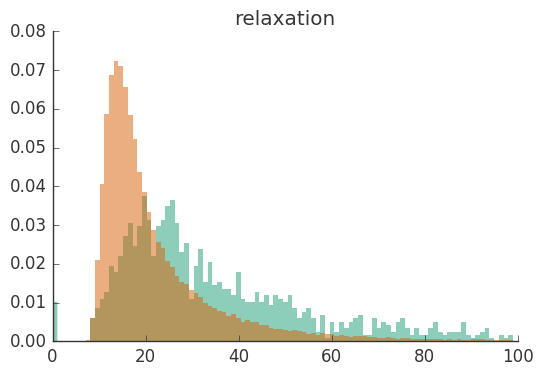

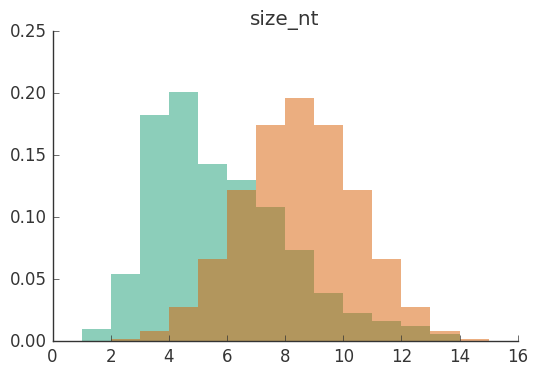

In [29]:
for variable in bins:
    compare_dist(temp, df, variable, bins[variable])
    ax = plt.gca()
    hide_axis(ax)
    ax.set_title(variable)

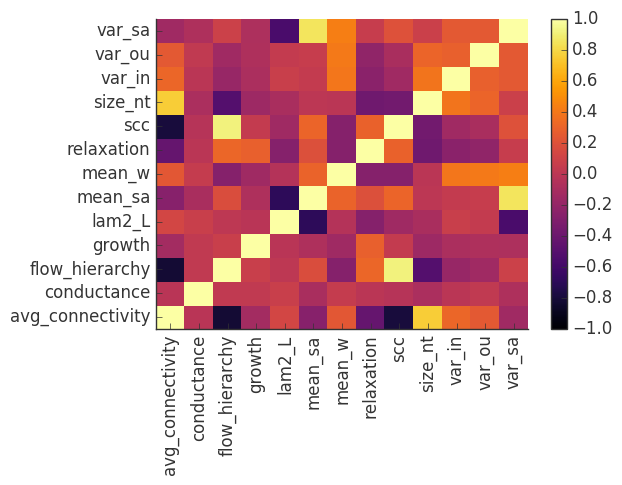

In [30]:
col = [u'avg_connectivity', u'conductance', u'flow_hierarchy', u'growth',
       u'lam2_L', u'mean_sa', u'mean_w', u'relaxation',
       u'scc', u'size_nt', u'var_in', u'var_ou', u'var_sa']
x = df.get(col)
corr = x.corr()

f = plt.figure()
ax = plt.gca()
heatmap = ax.pcolormesh(range(14), range(14), corr, cmap='inferno', vmin=-1, vmax=1)
plt.colorbar(heatmap)
hide_axis(ax)
ax.set_xlim(0,13)
ax.set_xticks(np.arange(13)+0.5)
ax.set_xticklabels(col, rotation=90)
ax.set_ylim(0,13)
ax.set_yticks(np.arange(13)+0.5)
ax.set_yticklabels(col, rotation=0);

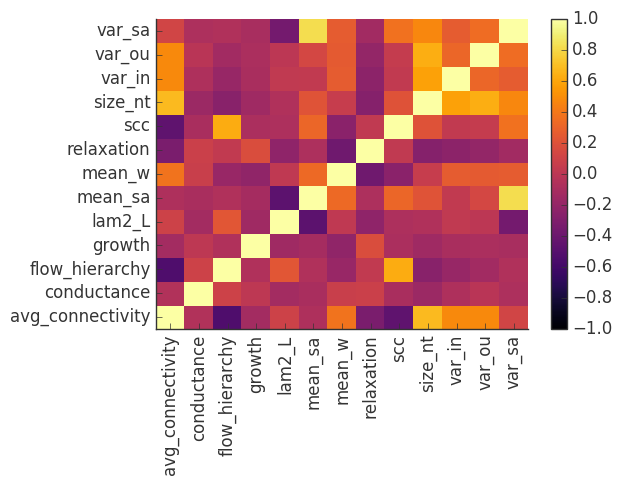

In [31]:
col = [u'avg_connectivity', u'conductance', u'flow_hierarchy', u'growth',
       u'lam2_L', u'mean_sa', u'mean_w', u'relaxation',
       u'scc', u'size_nt', u'var_in', u'var_ou', u'var_sa']
x_temp = temp.get(col)
corr_temp = x_temp.corr()

f = plt.figure()
ax = plt.gca()
heatmap = ax.pcolormesh(range(14), range(14), corr_temp, cmap='inferno', vmin=-1, vmax=1)
plt.colorbar(heatmap)
hide_axis(ax)
ax.set_xlim(0,13)
ax.set_xticks(np.arange(13)+0.5)
ax.set_xticklabels(col, rotation=90)
ax.set_ylim(0,13)
ax.set_yticks(np.arange(13)+0.5)
ax.set_yticklabels(col, rotation=0);

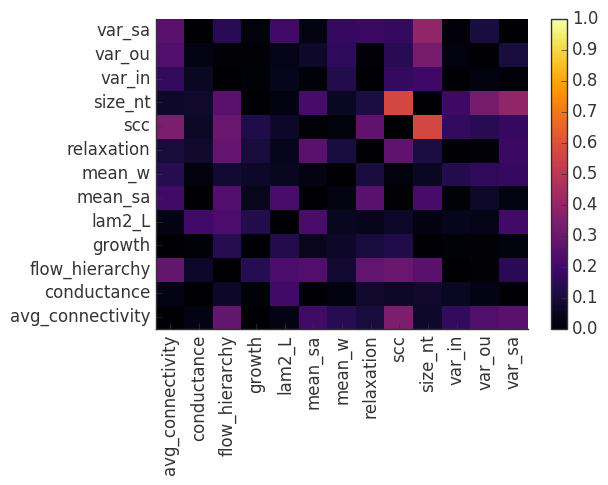

In [32]:
f = plt.figure()
ax = plt.gca()
heatmap = ax.pcolormesh(range(14), range(14), np.abs(corr_temp - corr), cmap='inferno', vmin=0, vmax=1)
plt.colorbar(heatmap)
hide_axis(ax)
ax.set_xlim(0,13)
ax.set_xticks(np.arange(13)+0.5)
ax.set_xticklabels(col, rotation=90)
ax.set_ylim(0,13)
ax.set_yticks(np.arange(13)+0.5)
ax.set_yticklabels(col, rotation=0);

### Asymptotic solution

In [41]:
nt_test = "0000100010010010"
np.var(azm.asymptotic_solution(nt_test)[0])

0.014599558239477044

In [42]:
df["var_asymp"] = df["nt_str"].map(lambda x: np.var(azm.asymptotic_solution(x)[0]))

In [62]:
print(df.sample(3))

       avg_connectivity  conductance  flow_hierarchy     growth    lam2_L  \
25924          0.738095     0.476075        0.248332  15.209110  0.381020   
52525          1.069444     0.667515        0.330895  16.055630  0.292274   
21593          1.285714     0.693298        0.000000  18.571449  0.637607   

        mean_sa    mean_w  nt_id            nt_str  relaxation  scc  size_nt  \
25924  0.014114  0.009118  25925  0110010101000101   29.469026    4        7   
52525  0.008522  0.007211  52526  1100110100101110   39.464380    4        9   
21593  0.003843  0.007743  21594  0101010001011010   18.571449    1        7   

         var_in    var_ou    var_sa  var_asymp  
25924  0.000287  0.000396  0.000224   0.002298  
52525  0.000660  0.000449  0.000152   0.006308  
21593  0.000137  0.000270  0.000010   0.001230  


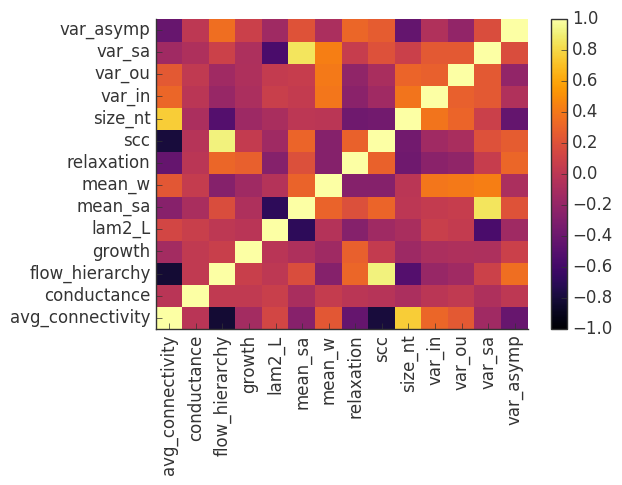

In [48]:
col = [u'avg_connectivity', u'conductance', u'flow_hierarchy', u'growth',
       u'lam2_L', u'mean_sa', u'mean_w', u'relaxation',
       u'scc', u'size_nt', u'var_in', u'var_ou', u'var_sa', u'var_asymp']
x_temp = df.get(col)
corr_temp = x_temp.corr()
n = len(col)

f = plt.figure()
ax = plt.gca()
heatmap = ax.pcolormesh(range(n+1), range(n+1), corr_temp, cmap='inferno', vmin=-1, vmax=1)
plt.colorbar(heatmap)
hide_axis(ax)
ax.set_xlim(0,n)
ax.set_xticks(np.arange(n)+0.5)
ax.set_xticklabels(col, rotation=90)
ax.set_ylim(0,n)
ax.set_yticks(np.arange(n)+0.5)
ax.set_yticklabels(col, rotation=0);

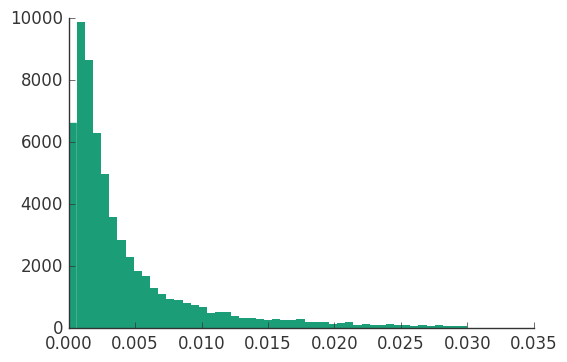

In [142]:
plt.hist(df["var_asymp"].values, bins["var_asymp"], lw=0)
hide_axis(plt.gca())

In [107]:
bins_scatter = {'avg_connectivity':(0,3), 
        'scc':(0,12), 
        'flow_hierarchy':(0,1),
        'size_nt':(0,16),
        'growth':(0,100),
        'relaxation':(0,200),
        'conductance':(0,50),
        'var_asymp':(0,0.03),
       }

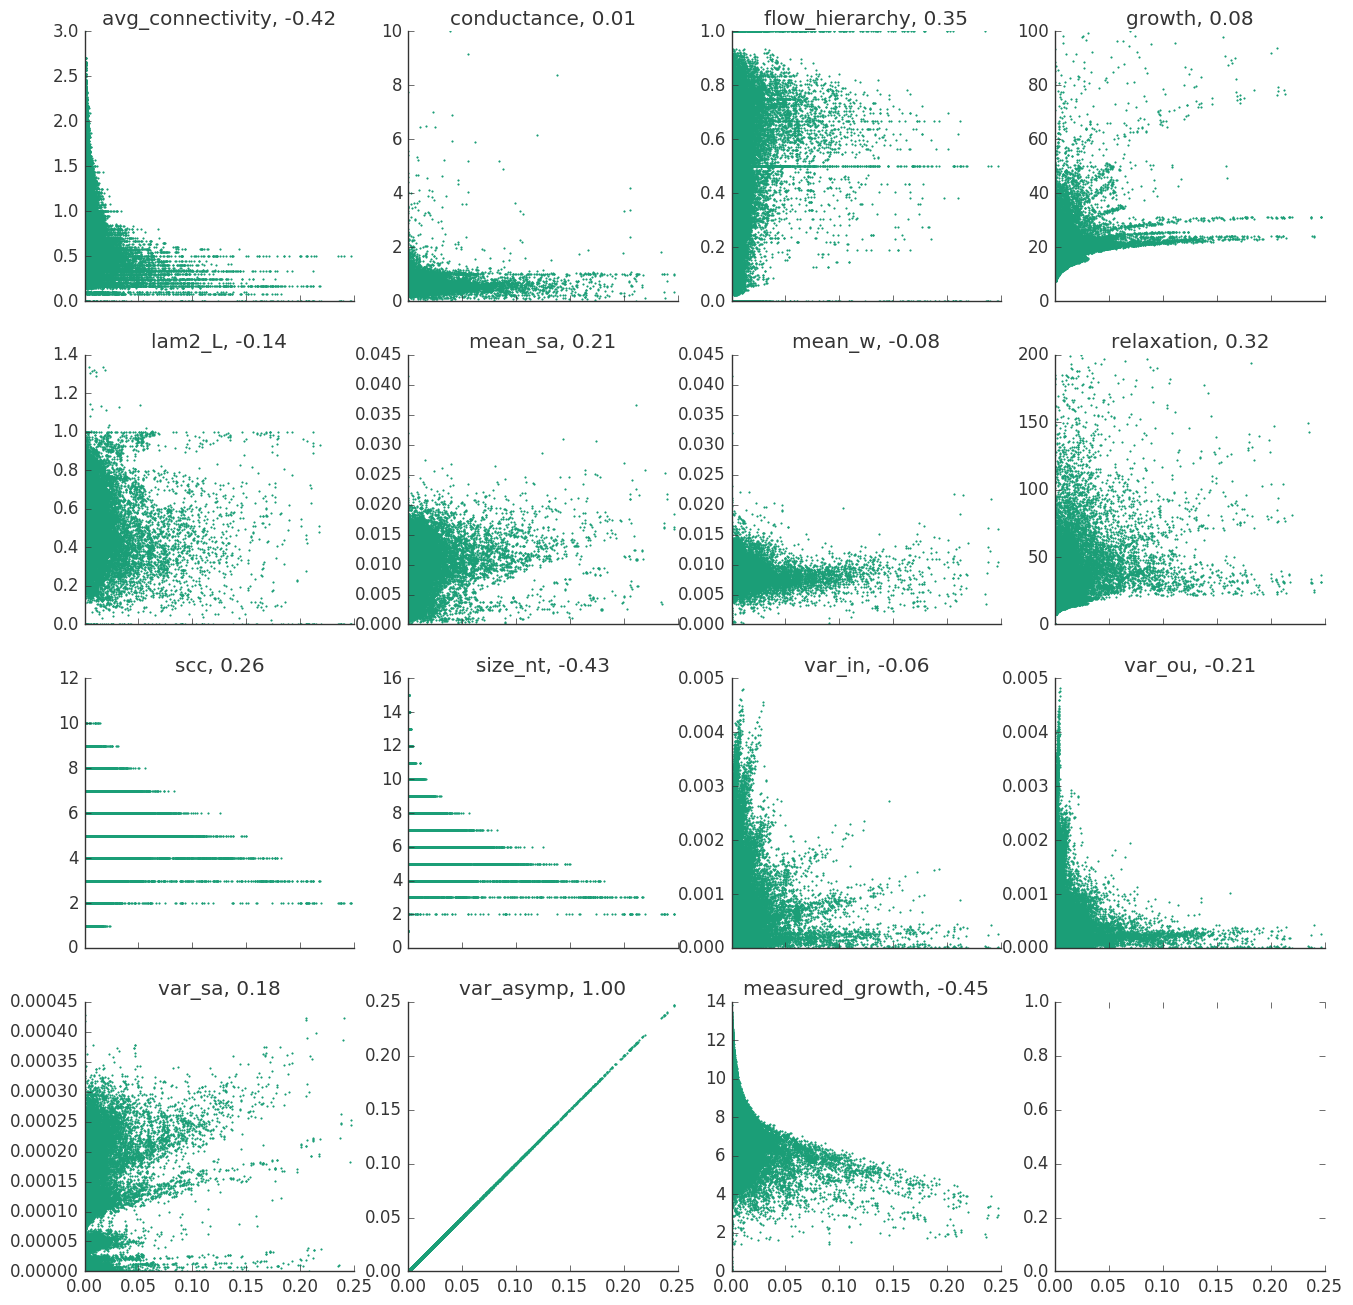

In [155]:
col = [u'avg_connectivity', u'conductance', u'flow_hierarchy', u'growth',
       u'lam2_L', u'mean_sa', u'mean_w', u'relaxation',
       u'scc', u'size_nt', u'var_in', u'var_ou', u'var_sa', u'var_asymp', u'measured_growth']

x_temp = df.get(col)
corr_temp = x_temp.corr()

f, axa = plt.subplots(4, 4, sharex=True)
f.set_figheight(16)
f.set_figwidth(16)

for i, var in enumerate(col):
    ax = axa[i/4,i%4]
    ax.plot(df["var_asymp"].values, df[var], '.', ms=2, color=colors[0])
    hide_axis(ax)
    if var in bins_scatter:
        ax.set_ylim(bins_scatter[var])
    ax.set_title("%s, %.2f"%(var, corr_temp.values[col.index("var_asymp"), col.index(var)]))

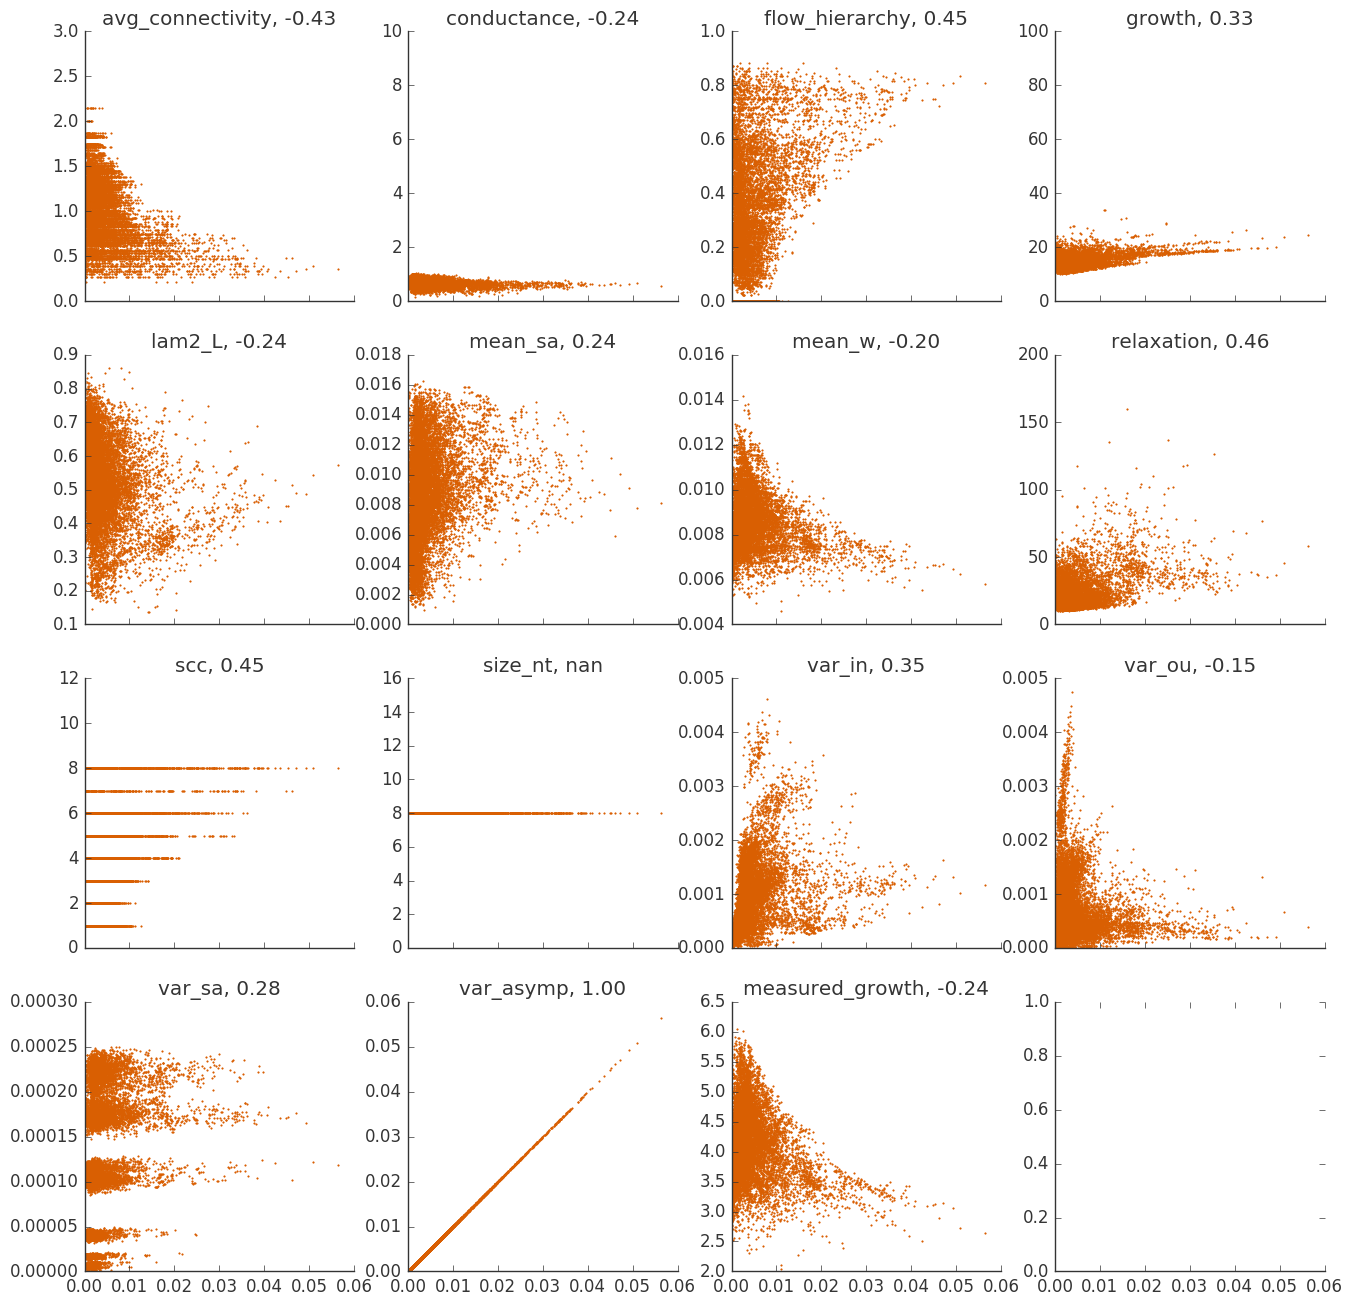

In [174]:
col = [u'avg_connectivity', u'conductance', u'flow_hierarchy', u'growth',
       u'lam2_L', u'mean_sa', u'mean_w', u'relaxation',
       u'scc', u'size_nt', u'var_in', u'var_ou', u'var_sa', u'var_asymp', u'measured_growth']

df_temp = df[df.size_nt == 8]
x_temp = df_temp.get(col)
corr_temp = x_temp.corr()

f, axa = plt.subplots(4, 4, sharex=True)
f.set_figheight(16)
f.set_figwidth(16)

for i, var in enumerate(col):
    ax = axa[i/4,i%4]
    ax.plot(df_temp["var_asymp"].values, df_temp[var], '.', ms=2, color=colors[1])
    hide_axis(ax)
    if var in bins_scatter:
        ax.set_ylim(bins_scatter[var])
    ax.set_title("%s, %.2f"%(var, corr_temp.values[col.index("var_asymp"), col.index(var)]))

### Measured growth

In [157]:
nt_test = "0001000010010010"
sum(azm.az_solve(nt_test, [1]*nt_test.count("1"), 60, normed=False)[-1])/nt_test.count("1")

4.5173206922543327

In [158]:
df["measured_growth"] = df["nt_str"].map(lambda x: np.log(sum(azm.az_solve(x, [1]*x.count("1"), 60, normed=False)[-1])/x.count("1")))

In [159]:
print(df.sample(3))

       avg_connectivity  conductance  flow_hierarchy     growth    lam2_L  \
7443           0.833333     0.997452        0.526064  14.285261  0.484426   
5186           0.950000     0.937500        0.151607  22.836772  0.838380   
53533          0.642857     0.534998        0.631201  19.837829  0.521070   

        mean_sa    mean_w  nt_id            nt_str  relaxation  scc  size_nt  \
7443   0.010433  0.013136   7444  0001110100010100   16.353979    4        6   
5186   0.003040  0.008908   5187  0001010001000011   22.836772    2        5   
53533  0.009487  0.006986  53534  1101000100011110   62.870383    6        8   

         var_in    var_ou    var_sa  var_asymp  measured_growth  
7443   0.002318  0.002374  0.000209   0.009494         4.292281  
5186   0.000034  0.000570  0.000011   0.000597         2.639256  
53533  0.000952  0.000386  0.000164   0.006562         3.202050  


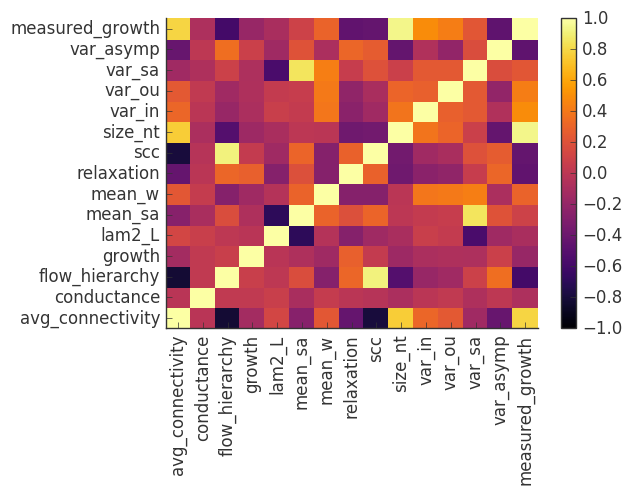

In [135]:
col = [u'avg_connectivity', u'conductance', u'flow_hierarchy', u'growth',
       u'lam2_L', u'mean_sa', u'mean_w', u'relaxation',
       u'scc', u'size_nt', u'var_in', u'var_ou', u'var_sa', u'var_asymp', u'measured_growth']
x_temp = df.get(col)
corr_temp = x_temp.corr()
n = len(col)

f = plt.figure()
ax = plt.gca()
heatmap = ax.pcolormesh(range(n+1), range(n+1), corr_temp, cmap='inferno', vmin=-1, vmax=1)
plt.colorbar(heatmap)
hide_axis(ax)
ax.set_xlim(0,n)
ax.set_xticks(np.arange(n)+0.5)
ax.set_xticklabels(col, rotation=90)
ax.set_ylim(0,n)
ax.set_yticks(np.arange(n)+0.5)
ax.set_yticklabels(col, rotation=0);

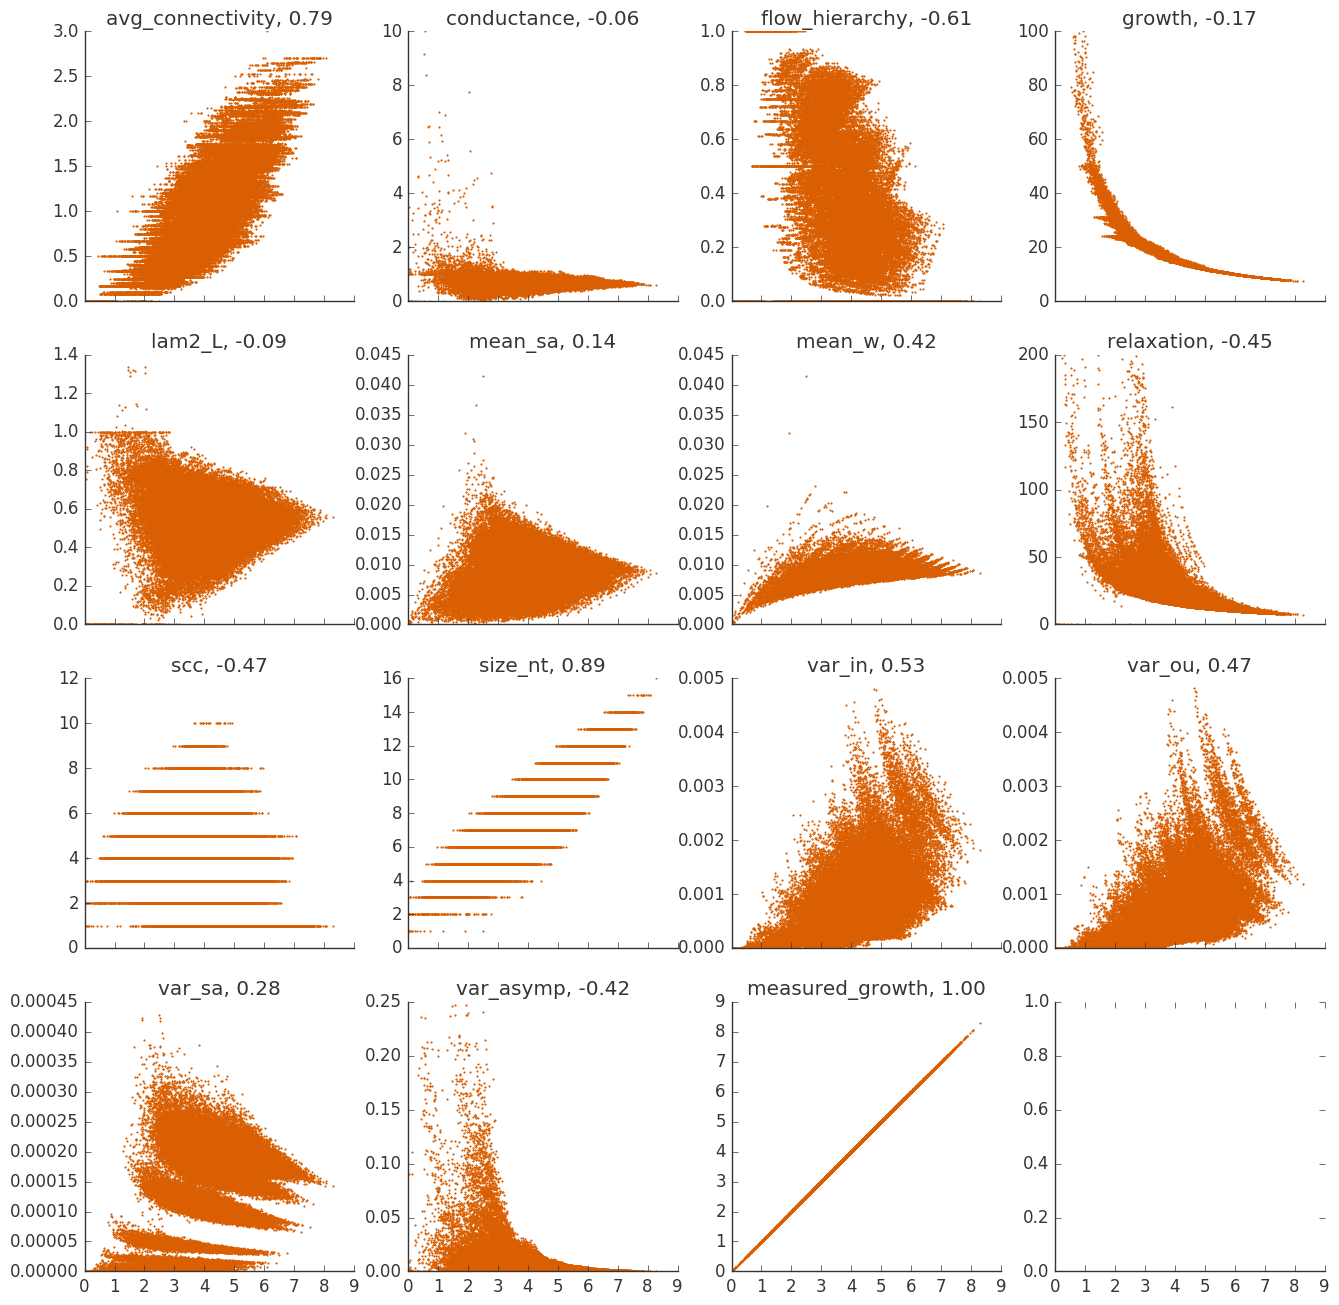

In [160]:
col = [u'avg_connectivity', u'conductance', u'flow_hierarchy', u'growth',
       u'lam2_L', u'mean_sa', u'mean_w', u'relaxation',
       u'scc', u'size_nt', u'var_in', u'var_ou', u'var_sa', u'var_asymp', u'measured_growth']

x_temp = df.get(col)
corr_temp = x_temp.corr()

f, axa = plt.subplots(4, 4, sharex=True)
f.set_figheight(16)
f.set_figwidth(16)

for i, var in enumerate(col):
    ax = axa[i/4,i%4]
    ax.plot(df["measured_growth"].values, df[var], '.', ms=2, color=colors[1])
    hide_axis(ax)
    if var in bins_scatter:
        ax.set_ylim(bins_scatter[var])
    ax.set_title("%s, %.2f"%(var, corr_temp.values[col.index("measured_growth"), col.index(var)]))

##### Limit to size == 8

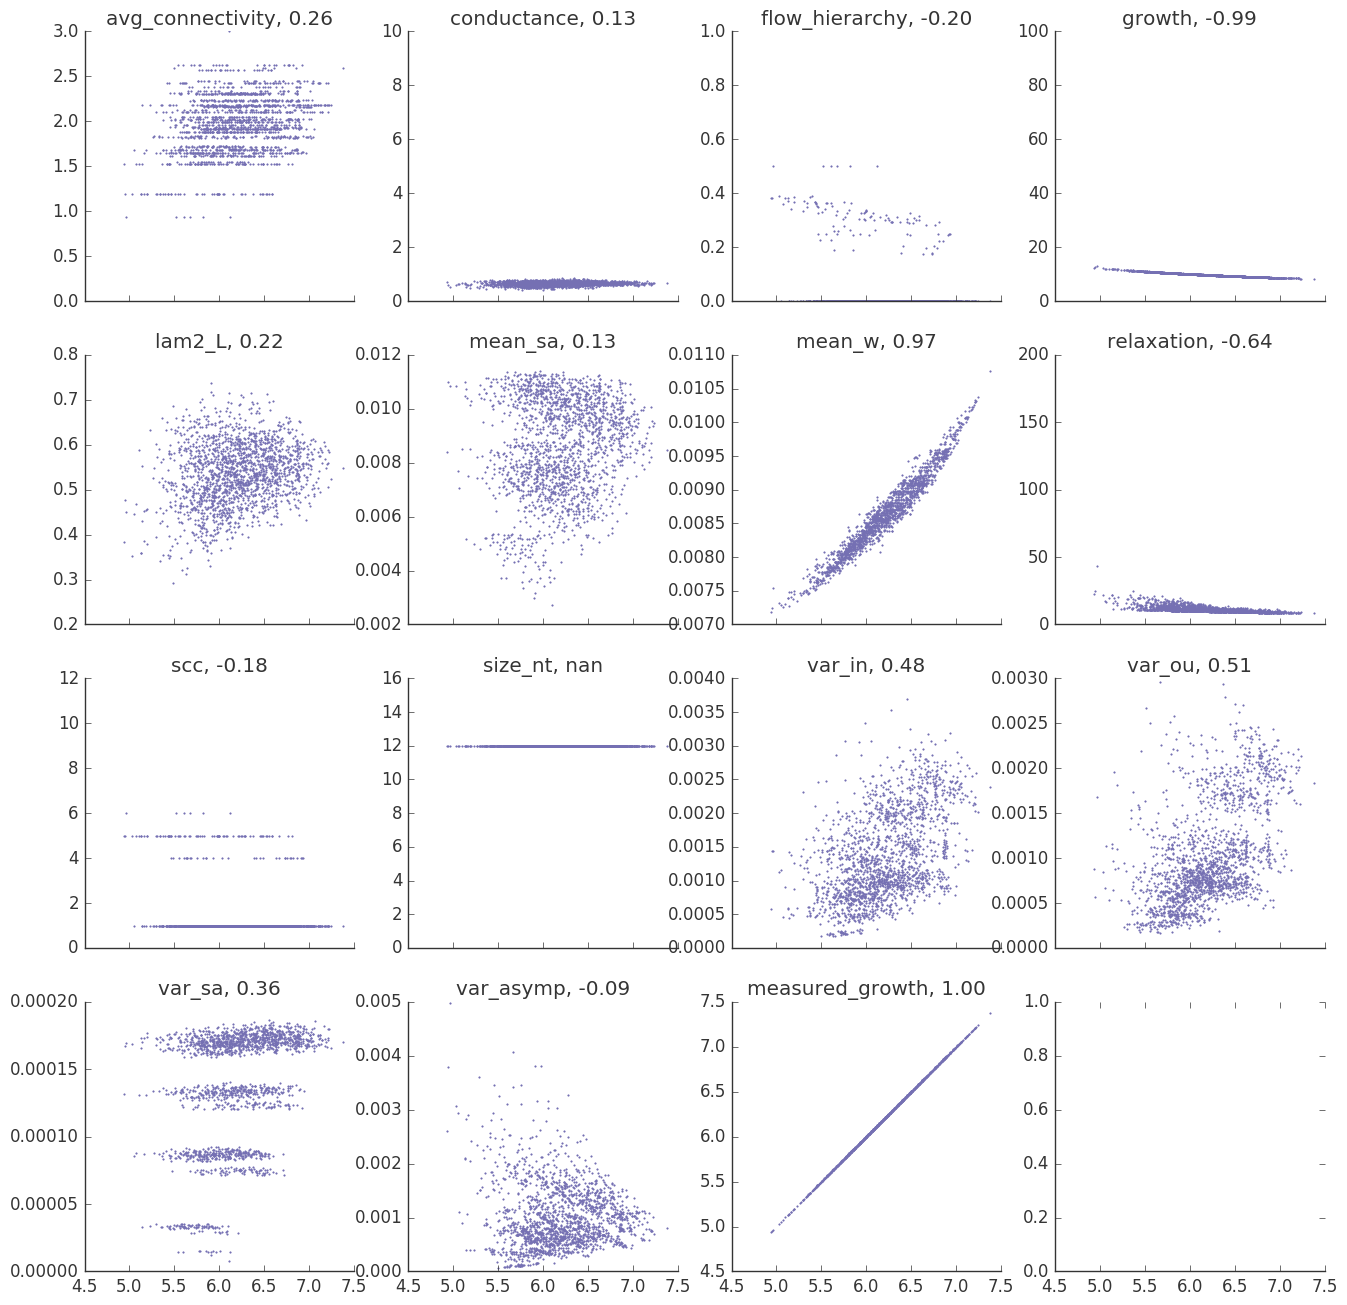

In [178]:
col = [u'avg_connectivity', u'conductance', u'flow_hierarchy', u'growth',
       u'lam2_L', u'mean_sa', u'mean_w', u'relaxation',
       u'scc', u'size_nt', u'var_in', u'var_ou', u'var_sa', u'var_asymp', u'measured_growth']


df_temp = df[df.size_nt == 12]
x_temp = df_temp.get(col)
corr_temp = x_temp.corr()

f, axa = plt.subplots(4, 4, sharex=True)
f.set_figheight(16)
f.set_figwidth(16)

for i, var in enumerate(col):
    ax = axa[i/4,i%4]
    ax.plot(df_temp["measured_growth"].values, df_temp[var], '.', ms=2, color=colors[2])
    hide_axis(ax)
    if var in bins_scatter:
        ax.set_ylim(bins_scatter[var])
    ax.set_title("%s, %.2f"%(var, corr_temp.values[col.index("measured_growth"), col.index(var)]))

### Correlation matrices with size selection

In [180]:
range(3,15)

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

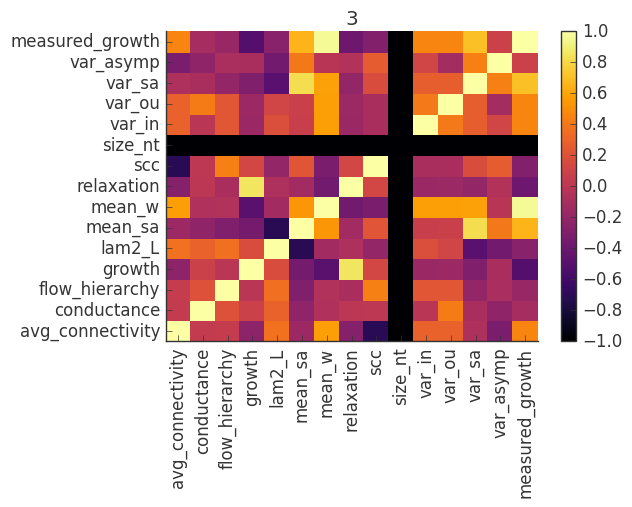

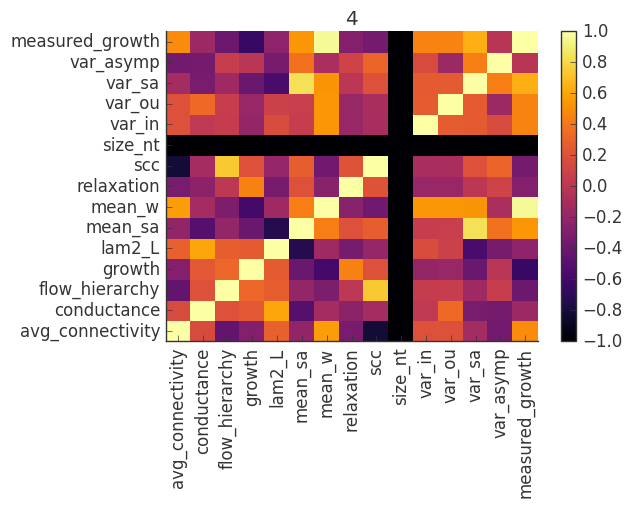

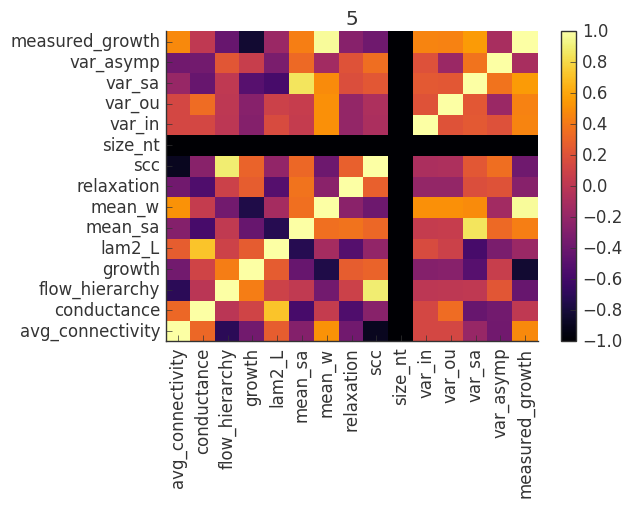

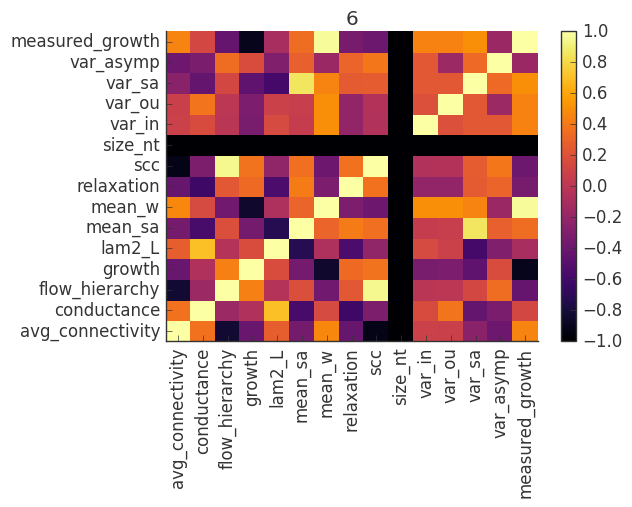

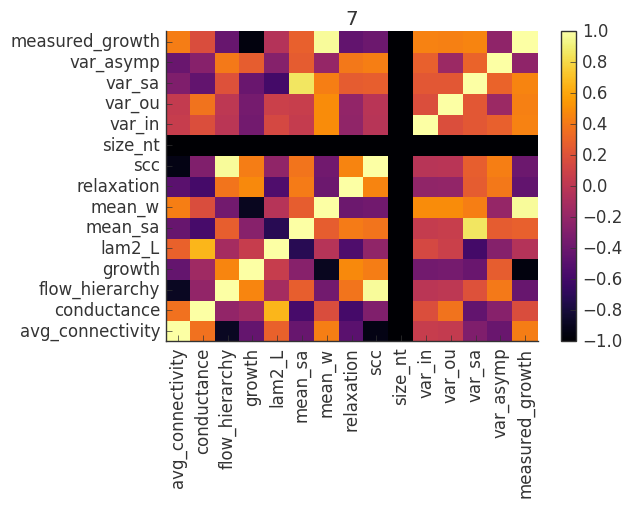

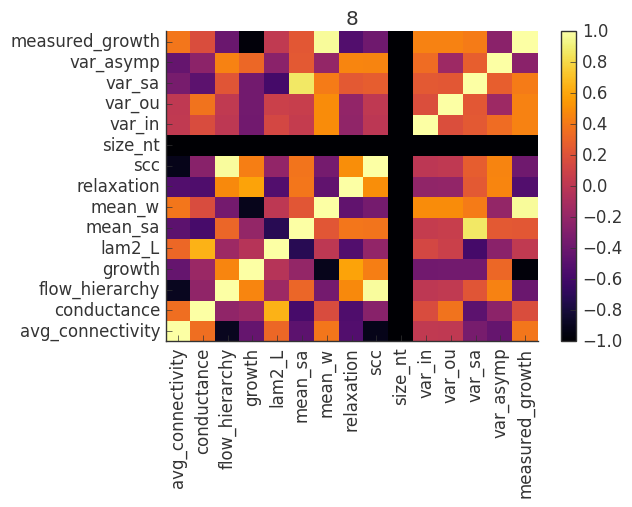

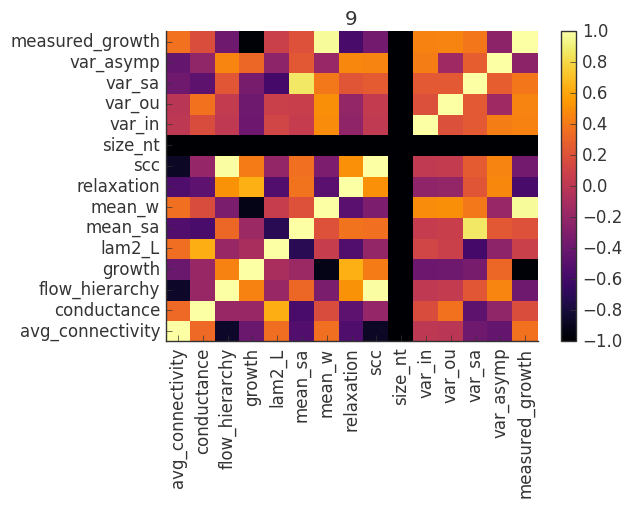

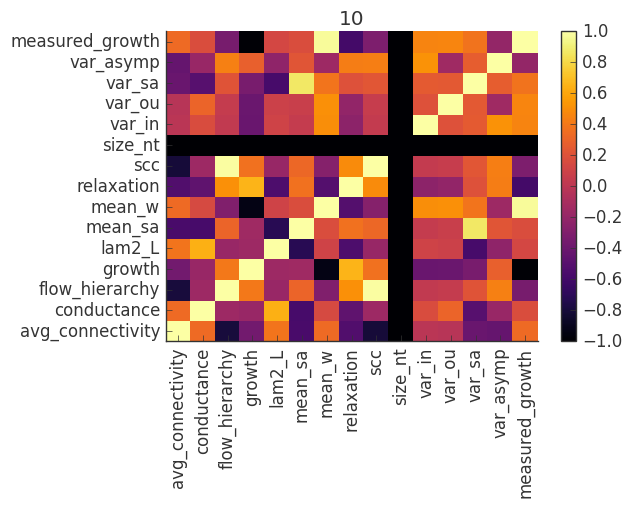

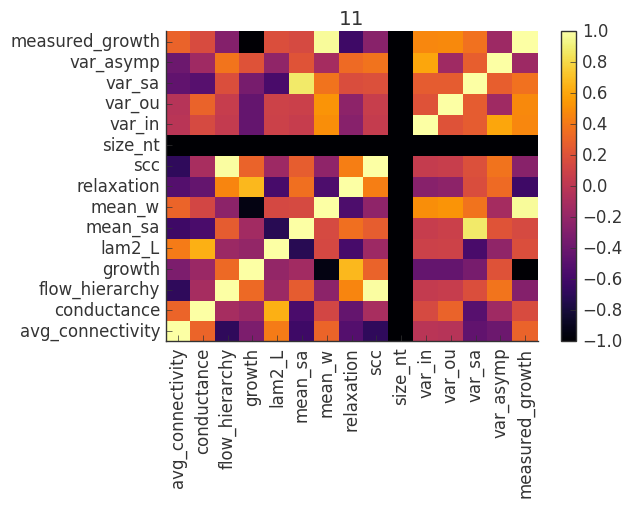

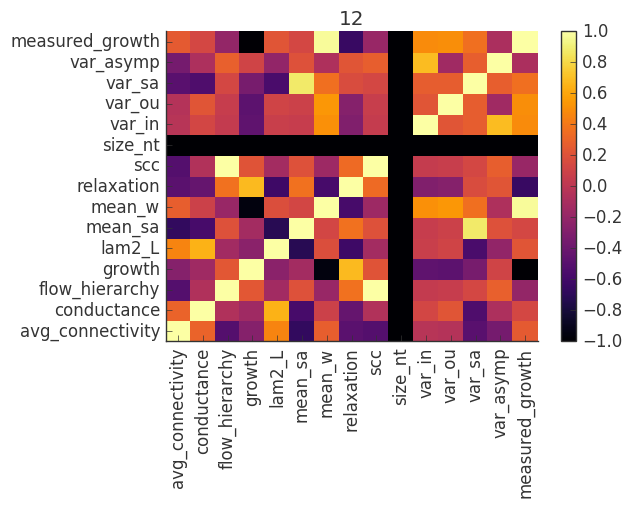

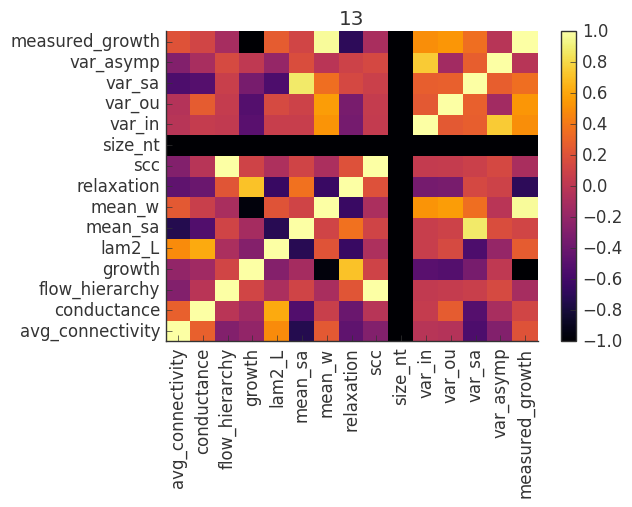

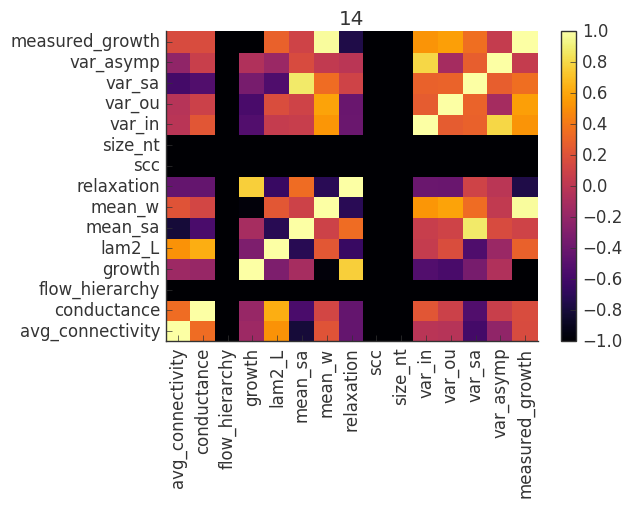

In [182]:
col = [u'avg_connectivity', u'conductance', u'flow_hierarchy', u'growth',
       u'lam2_L', u'mean_sa', u'mean_w', u'relaxation',
       u'scc', u'size_nt', u'var_in', u'var_ou', u'var_sa', u'var_asymp', u'measured_growth']

for s in range(3,15):
    df_temp = df[df.size_nt == s]
    x_temp = df_temp.get(col)
    corr_temp = x_temp.corr()
    n = len(col)

    f = plt.figure()
    ax = plt.gca()
    heatmap = ax.pcolormesh(range(n+1), range(n+1), corr_temp, cmap='inferno', vmin=-1, vmax=1)
    plt.colorbar(heatmap)
    hide_axis(ax)
    ax.set_xlim(0,n)
    ax.set_xticks(np.arange(n)+0.5)
    ax.set_xticklabels(col, rotation=90)
    ax.set_ylim(0,n)
    ax.set_yticks(np.arange(n)+0.5)
    ax.set_yticklabels(col, rotation=0);
    ax.set_title(s)

# 11/01/17

In [189]:
def add_bool(x, y):
    s = ""
    for i in range(len(x)):
        if x[i] == '1' or y[i] == '1':
            s += '1'
        else:
            s += '0'
    return s

In [194]:
def compete_two_nt(a, b):
    sol = azm.asymptotic_solution(add_bool(a,b))
    a = transform(a)
    b = transform(b)
    return sum([sol[0][sol[1].index(e)] for e in a])/sum([sol[0][sol[1].index(e)] for e in b])

In [195]:
a = "0000000000101100"
b = "1001010000000000"
print(azm.asymptotic_solution(a))
print(azm.asymptotic_solution(b))
print(azm.asymptotic_solution(add_bool(a,b)))
print(compete_two_nt(a, b))

(array([ 0.30243834,  0.27197708,  0.42558458]), ['UU', 'GA', 'GC'])
(array([ 0.04711524,  0.6615435 ,  0.29134127]), ['AA', 'AG', 'CC'])
(array([ 0.13018368,  0.16735462,  0.1482082 ,  0.27586162,  0.13018368,
        0.1482082 ]), ['AA', 'AG', 'CC', 'UU', 'GA', 'GC'])
1.2434275804


In [242]:
%%time
liste_nt = list(df[df.size_nt == 3].nt_str)
n = len(liste_nt)
competition = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        competition[i,j] = compete_two_nt(liste_nt[i], liste_nt[j])

Wall time: 31.2 s


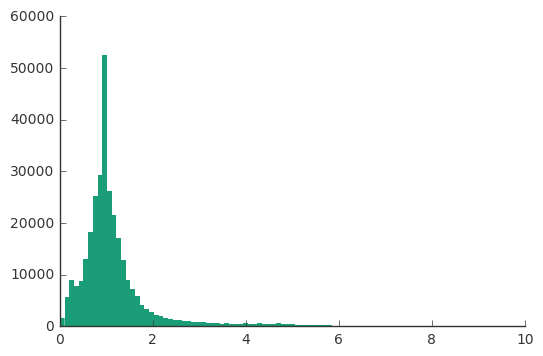

In [243]:
f = plt.figure()
ax = plt.gca()

ax.hist([x for x in competition.flatten() if x > 0], np.linspace(0,10,100), lw=0)
hide_axis(ax)

(0, 560L)

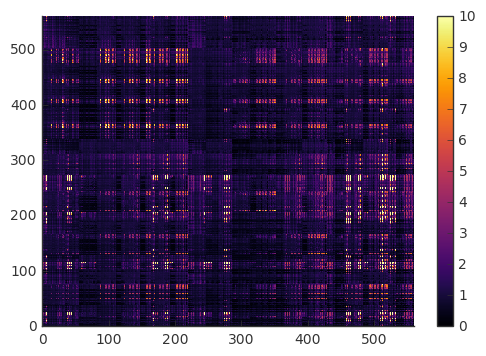

In [244]:
f = plt.figure()
ax = plt.gca()

n = competition.shape[0]
heatmap = ax.pcolormesh(range(n+1), range(n+1), competition[::-1,:], cmap='inferno', vmin=0, vmax=10)
plt.colorbar(heatmap)
hide_axis(ax)
ax.set_xlim(0,n)
#ax.set_xticks(np.arange(n)+0.5)
#ax.set_xticklabels(col, rotation=90)
ax.set_ylim(0,n)
#ax.set_yticks(np.arange(n)+0.5)
#ax.set_yticklabels(col, rotation=0);
#ax.set_title(s)

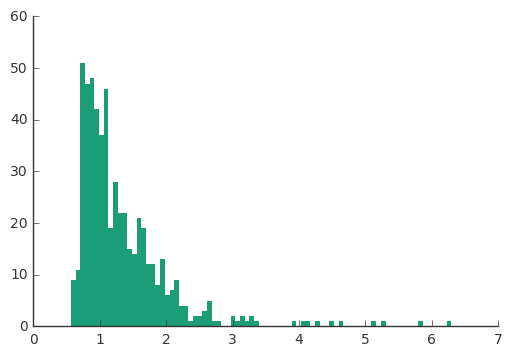

In [251]:
plt.hist(competition.mean(0),np.linspace(0,7,100), lw=0)
hide_axis(plt.gca())

In [290]:
top = 0
idx = 0
for i in range(n):
    for j in range(n):
        if competition[i,j] > top:
            top = competition[i,j]
            idx = (i, j)
print(idx, top)

((559, 226), 112.85654462475418)


In [291]:
compete_two_nt(liste_nt[559], liste_nt[226])

112.85654462475418

In [293]:
print(map(transform, (liste_nt[559], liste_nt[226])))

[['AA', 'AC', 'AU'], ['AG', 'UG', 'GG']]


In [299]:
azm.asymptotic_solution(add_bool(liste_nt[559],liste_nt[226]))

(array([ 0.01157708,  0.17505957,  0.80458036,  0.00292766,  0.00292766,
         0.00292766]), ['AA', 'AC', 'AU', 'AG', 'UG', 'GG'])

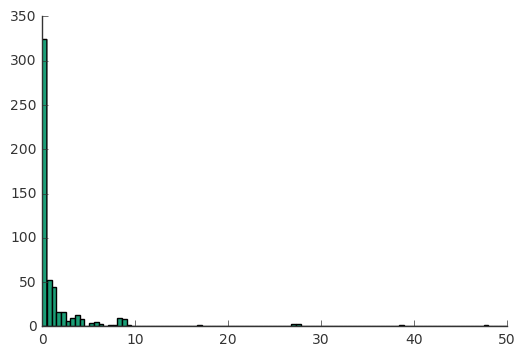

In [313]:
plt.hist(competition.var(1), np.linspace(0,50,100))
hide_axis(plt.gca())

In [314]:
s1 = set()
s2 = set()
for i in range(10):
    s1.add(i)
    s2.add(i+10)

### Sample final space

In [132]:
def where(x, l):
    for i in range(len(l)):
        if x < l[i]:
            return i-1
    return len(l)-2
        
def prob_pick(x, h):
    i = where(x, h[1])
    return 1/h[0][i]

In [137]:
weight = pd.DataFrame()

for c in list(df.columns):
    try:
        h = np.histogram(df[c], bins='auto', density=True)
        weight[c] = df[c].map(lambda x: prob_pick(x, h))
    except:
        print("Column %s ignored"%c)
    
del weight["nt_id"]
weight

Column nt_str ignored


avg_connectivity  conductance  flow_hierarchy        growth     lam2_L  \
0             15.829710    38.110266        0.054748  19693.725455   3.478971   
1             15.829710    38.110266        0.054748  19693.725455   3.478971   
2             15.829710     0.871092        0.054748   4923.431364   3.478971   
3             15.829710    38.110266        0.054748   9846.862728   3.478971   
4              1.222342     0.871092        0.884461   6564.575152   3.478971   
5              1.222342     0.871092        0.884461   1790.338678   3.478971   
6              1.998889     4.619426        1.492417   1094.095859   5.958238   
7             15.829710    38.110266        0.054748   9846.862728   3.478971   
8             15.829710     0.871092        0.054748  19693.725455   3.478971   
9             15.829710     0.871092        0.054748  19693.725455   3.478971   
10            15.829710     5.594168        0.054748   6564.575152   5.958238   
11             1.222342     0.871092        0.884461   6564.575152   3.478971   
12             1.998889     4.148056        1.492417   3282.287576   5.958238   
13             1.998889     3.718075        1.492417   2461.715682   5.958238   
14             2.699770     0.871092        1.386808   1406.694675   5.958238   
15            15.829710    38.110266        0.054748  19693.725455   3.478971   
16            15.829710   609.764259        0.054748  19693.725455   3.478971   
17            15.829710     2.617014        0.054748  19693.725455   3.478971   
18            15.829710     0.368660        0.054748   6564.575152   0.305461   
19            15.829710     0.942449        0.054748   9846.862728   3.478971   
20             3.100466     0.358474        0.884461   4923.431364   0.381152   
21             3.100466     0.371355        0.884461   1406.694675   0.293028   
22             3.100466     0.431234        1.492417   1312.915030   0.499390   
23             1.222342   609.764259        3.266298  19693.725455   3.478971   
24             3.100466   609.764259        3.266298  19693.725455  17.278889   
25             3.100466    30.488213        3.266298   9846.862728   0.422811   
26             6.308375     1.062307        3.266298   4923.431364   0.640750   
27             1.222342     1.286422        1.696392   9846.862728   0.483551   
28             1.998889     0.747260        1.777365   4923.431364   0.628323   
29             1.998889     0.371355        1.777365   1158.454439   0.499390   
...                 ...          ...             ...           ...        ...   
65505          4.007206     0.347840        0.054748     35.293415   0.328913   
65506         20.226852     0.461593        0.054748    155.068704   0.305461   
65507          1.252991     0.363821        0.948683     23.698827   0.315885   
65508          3.267415     0.421108        0.054748     80.711990   0.293028   
65509          2.909342     0.357633        0.054748     47.454760   0.321169   
65510         26.547743     0.402485        0.054748    358.067736   0.283106   
65511          2.949749     0.363821        0.054748     23.698827   0.328913   
65512         23.597994     0.523403        0.054748     80.711990   0.283106   
65513          5.740053     0.368660        0.054748     47.454760   0.321169   
65514         35.396991     0.421982        0.054748    358.067736   0.292532   
65515          2.949749     0.345476        0.054748     35.293415   0.328913   
65516         20.226852     0.403283        0.054748    155.068704   0.283106   
65517         15.170139     0.345476        0.054748     80.711990   0.340136   
65518         53.095486     0.402485        0.054748    358.067736   0.292532   
65519          3.138649     0.402485        1.015984     80.711990   0.283106   
65520          7.964323     0.368660        0.054748    358.067736   0.357248   
65521          7.964323     0.481266        0.054748    155.068704   0.308368   
65522         53.095486     0.402485  

In [260]:
we = weight[["conductance"]].values
we = we/we.sum(0)
we

array([[  3.90625000e-03,   1.97628458e-03],
       [  3.90625000e-03,   2.78546101e-06],
       [  5.20833333e-04,   1.06826194e-04],
       ..., 
       [  3.90625000e-03,   2.33189922e-06],
       [  3.90625000e-03,   2.10131269e-06],
       [  6.25000000e-02,   2.33189922e-06]])

(0, 0.01)

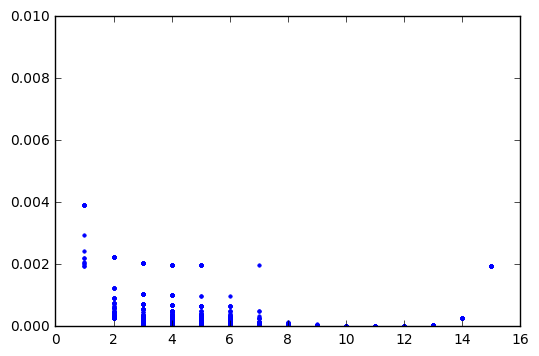

In [261]:
plt.plot(df.size_nt.values, we.mean(1),'.',ms=5)
ax = plt.gca()
ax.set_ylim(0,0.01)

In [262]:
nt_sample = np.random.choice(df.nt_str, size=1152, replace=False, p=we.mean(1))
rand_sample = df[df.nt_str.isin(nt_sample)]

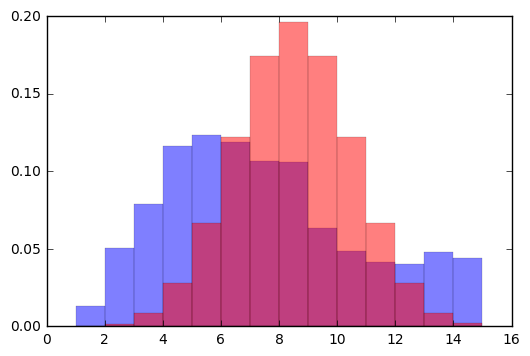

In [263]:
compare_dist(rand_sample, df, "size_nt", bins=range(16))

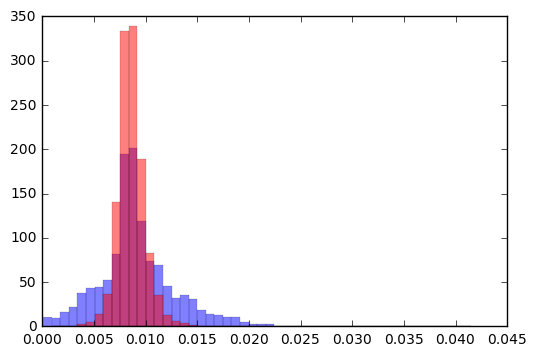

In [264]:
compare_dist(rand_sample, df, "mean_w", bins=50);

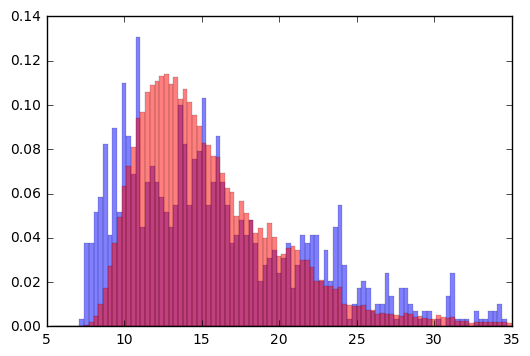

In [265]:
compare_dist(rand_sample, df, "growth", np.linspace(5,35,100))

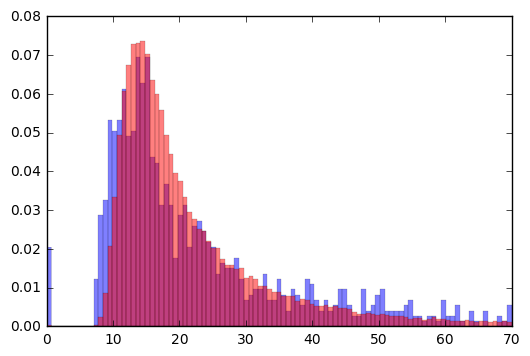

In [266]:
compare_dist(rand_sample, df, "relaxation", bins=np.linspace(0,70,100));

### Misc

    avg_connectivity  conductance  flow_hierarchy     growth  lam2_L  mean_sa  \
71               1.0     2.476923             0.0  55.775987     0.0  0.00215   

      mean_w  nt_id            nt_str  relaxation  scc  size_nt    var_in  \
71  0.009125     72  0000000001001000   31.687962    1        2  0.000013   

      var_ou    var_sa  
71  0.000013  0.000003  


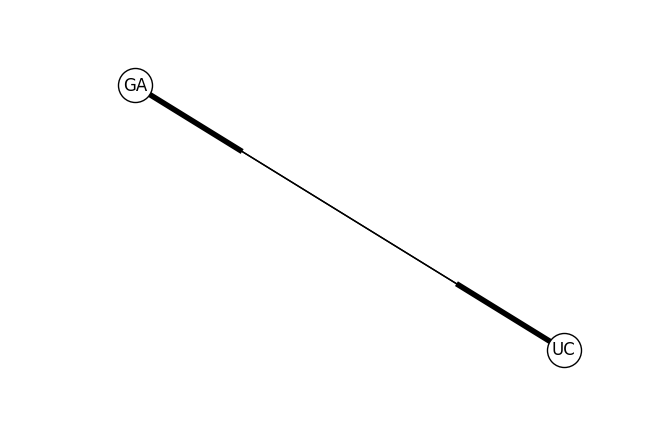

In [56]:
net = ["GA", "UC"]
az_draw(net)
print(df[df.nt_str == transform(net)])

      avg_connectivity  conductance  flow_hierarchy     growth    lam2_L  \
6927               1.5     1.106583             0.0  12.870728  0.602416   

      mean_sa    mean_w  nt_id            nt_str  relaxation  scc  size_nt  \
6927  0.00978  0.017996   6928  0001101100010000   12.870728    1        5   

       var_in    var_ou    var_sa  
6927  0.00193  0.001759  0.000254  


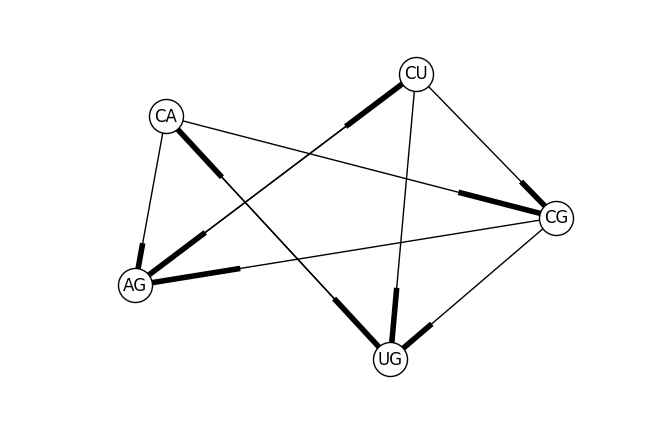

In [236]:
net = ["UG","CA","CG","AG","CU"]
az_draw(net)
print(df[df.nt_str == transform(net)])